# <span style="color:blue">MBA em Ciência de Dados</span>
# <span style="color:blue">Análise de Dados com Base em Processamento Massivo em Paralelo</span>

## <span style="color:blue">Aula 08: Explorando o Módulo pyspark.sql</span>
## <span style="color:blue">Respostas dos Exercícios</span>

**Material Produzido por:**<br>
>**Profa. Dra. Cristina Dutra de Aguiar**<br>

**CEMEAI - ICMC/USP São Carlos**

Esta lista contém os exercícios referentes à Aula 08. Por favor, procure por "Exercício" para encontrar a especificação dos exercícios e as suas respectivas respostas. Também é possível localizar os exercícios utilizando o menu de navegação. Por completude, o *notebook* possui todas as descrições apresentadas na parte prática da Aula 08. Recomenda-se fortemente que a lista de exercícios seja respondida antes de se consultar as respostas dos exercícios.

**IMPORTANTE: O uso do *framework* Spark requer diversas configurações no ambiente de desenvolvimento para executar o *notebook*. Dado que tal complexidade foge do escopo de nossa disciplina, recomenda-se que o *notebook* seja executado na plataforma de desenvolvimento COLAB. O uso do COLAB  proporciona um ambiente de desenvolvimento pré-configurado e remove a complexidade de instalação e configuração de pacotes e *frameworks* que são utilizados na disciplina.**

#1 Constelação de Fatos da BI Solutions

A aplicação de *data warehousing* da BI Solutions utiliza como base uma contelação de fatos, conforme descrita a seguir.

**Tabelas de dimensão**

- data (dataPK, dataCompleta, dataDia, dataMes, dataBimestre, dataTrimestre, dataSemestre, dataAno)
- funcionario (funcPK, funcMatricula, funcNome, funcSexo, funcDataNascimento, funcDiaNascimento, funcMesNascimento, funcAnoNascimento, funcCidade, funcEstadoNome, funcEstadoSigla, funcRegiaoNome, funcRegiaoSigla, funcPaisNome, funcPaisSigla)
- equipe (equipePK, equipeNome, filialNome, filialCidade, filialEstadoNome, filialEstadoSigla, filialRegiaoNome, filialRegiaoSigla, filialPaisNome, filialPaisSigla)
- cargo (cargoPK, cargoNome, cargoRegimeTrabalho, cargoEscolaridadeMinima, cargoNivel)
- cliente (clientePK, clienteNomeFantasia, clienteSetor, clienteCidade, clienteEstadoNome, clienteEstadoSigla, clienteRegiaoNome, clienteRegiaoSigla, clientePaisNome, clientePaisSigla)

**Tabelas de fatos**
- pagamento (dataPK, funcPK, equipePK, cargoPK, salario, quantidadeLancamentos)
- negociacao (dataPK, equipePK, clientePK, receita, quantidadeNegociacoes)


#2 Obtenção dos Dados da BI Solutions


## 2.1 Baixando o Módulo wget

Para baixar os dados referentes ao esquema relacional da constelação de fatos da BI Solutions, é utilizado o módulo  **wget**. O comando a seguir realiza a instalação desse módulo. <br>

In [ ]:
#instalando o módulo wget
%%capture
!pip install -q wget
!mkdir data

## 2.2 Obtenção dos Dados das Tabelas de Dimensão

Os comandos a seguir baixam os dados que povoam as tabelas de dimensão. 

In [ ]:
#baixando os dados das tabelas de dimensão
import wget

url = "https://raw.githubusercontent.com/GuiMuzziUSP/Data_Mart_BI_Solutions/main/data.csv"
wget.download(url, "data/data.csv")

url = "https://raw.githubusercontent.com/GuiMuzziUSP/Data_Mart_BI_Solutions/main/funcionario.csv"
wget.download(url, "data/funcionario.csv")

url = "https://raw.githubusercontent.com/GuiMuzziUSP/Data_Mart_BI_Solutions/main/equipe.csv"
wget.download(url, "data/equipe.csv")

url = "https://raw.githubusercontent.com/GuiMuzziUSP/Data_Mart_BI_Solutions/main/cargo.csv"
wget.download(url, "data/cargo.csv")

url = "https://raw.githubusercontent.com/GuiMuzziUSP/Data_Mart_BI_Solutions/main/cliente.csv"
wget.download(url, "data/cliente.csv")

'data/cliente (1).csv'

## 2.3 Obtenção dos Dados Tabelas de Fatos

Os comandos a seguir baixam os dados que povoam as tabelas de fatos. 

In [ ]:
#baixando os dados das tabelas de fatos
url = "https://raw.githubusercontent.com/GuiMuzziUSP/Data_Mart_BI_Solutions/main/pagamento.csv"
wget.download(url, "data/pagamento.csv")

url = "https://raw.githubusercontent.com/GuiMuzziUSP/Data_Mart_BI_Solutions/main/negociacao.csv"
wget.download(url, "data/negociacao.csv")

'data/negociacao (1).csv'

# 3 Apache Spark Cluster

## 3.1 Instalação

Neste *notebook* é criado um *cluster* Spark composto apenas por um **nó mestre**. Ou seja, o *cluster* não possui um ou mais **nós de trabalho** e o **gerenciador de cluster**. Nessa configuração, as tarefas (*tasks*) são realizadas no próprio *driver* localizado no **nó mestre**.

Para que o cluster possa ser criado, primeiramente é instalado o Java Runtime Environment (JRE) versão 8. 

In [ ]:
#instalando Java Runtime Environment (JRE) versão 8
%%capture
!apt-get remove openjdk*
!apt-get update --fix-missing
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Na sequência, é feito o *download* do Apache Spark versão 3.0.0.

In [ ]:
#baixando Apache Spark versão 3.0.0
%%capture
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz
!tar xf spark-3.0.0-bin-hadoop2.7.tgz && rm spark-3.0.0-bin-hadoop2.7.tgz

Na sequência, são configuradas as variáveis de ambiente JAVA_HOME e SPARK_HOME. Isto permite que tanto o Java quanto o Spark possam ser encontrados.

In [ ]:
import os
#configurando a variável de ambiente JAVA_HOME
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#configurando a variável de ambiente SPARK_HOME
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop2.7"

Por fim, são instalados dois pacotes da linguagem de programação Python, cujas funcionalidades são descritas a seguir.

> **Pacote findspark:** Usado para ler a variável de ambiente SPARK_HOME e armazenar seu valor na variável dinâmica de ambiente PYTHONPATH. Como resultado, Python pode encontrar a instalação do Spark. 

> **Pacote pyspark:** PySpark é a API do Python para Spark. Ela possibilita o uso de Python, considerando que o *framework* Apache Spark encontra-se desenvolvido na linguagem de programação Scala. 

In [ ]:
%%capture
#instalando o pacote findspark
!pip install -q findspark==1.4.2
#instalando o pacote pyspark
!pip install -q pyspark==3.0.0

## 3.2 Conexão

PySpark não é adicionado ao *sys.path* por padrão. Isso significa que não é possível importá-lo, pois o interpretador da linguagem Python não sabe onde encontrá-lo. 

Para resolver esse aspecto, é necessário instalar o módulo `findspark`. Esse módulo mostra onde PySpark está localizado. Os comandos a seguir têm essa finalidade.


In [ ]:
#importando o módulo findspark
import findspark
#carregando a variávels SPARK_HOME na variável dinâmica PYTHONPATH
findspark.init()

Depois de configurados os pacotes e módulos e inicializadas as variáveis de ambiente, é possível iniciar o uso do Spark na aplicação de `data warehousing`. Para tanto, é necessário importar o comando `SparkSession` do módulo `pyspark.sql`. São utilizados os seguintes conceitos: <br>

- `SparkSession`: permite a criação de `DataFrames`. Como resultado, as tabelas relacionais podem ser manipuladas por meio de `DataFrames` e é possível realizar consultas OLAP por meio de comandos SQL. <br>
- `builder`: cria uma instância de SparkSession. <br>
- `appName`: define um nome para a aplicação, o qual pode ser visto na interface de usuário web do Spark. <br> 
- `master`: define onde está o nó mestre do *cluster*. Como a aplicação é executada localmente e não em um *cluster*, indica-se isso pela *string* `local` seguida do parâmetro `[*]`. Ou seja, define-se que apenas núcleos locais são utilizados. 
- `getOrCreate`: cria uma SparkSession. Caso ela já exista, retorna a instância existente. 


**Observação**: A lista completa de todos os parâmetros que podem ser utilizados na inicialização do *cluster* pode ser encontrada neste [link](https://spark.apache.org/docs/latest/spark-standalone.html#cluster-launch-scripts).

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("pyspark-notebook").master("local[*]").getOrCreate()

# 4 Geração dos DataFrames da BI Solutions

Um `DataFrame` em Spark é equivalente a uma tabela relacional. Portanto, um `DataFrame` possui um esquema, uma ou mais linhas (ou tuplas) e uma ou mais colunas (ou atributos).


## 4.1 Métodos para Leitura e Escrita

### Método spark.read.csv()

``spark.read.csv()``

Realiza a leitura dos dados de um arquivo `.csv` e armazena esses dados em um `DataFrame`. Alguns parâmetros do método são: 

- `path`: indica o endereço do arquivo que é lido.

- `header`: indica se o arquivo possui um cabeçalho.

- `sep`: especifica o caractere que separa os campos do arquivo.

- `inferSchema`: infere o tipo de dados de cada atributo automaticamente a partir dos dados do arquivo `.csv`. Para que isto seja possível, existe a necessidade de se ler os dados mais uma vez. Se esse parâmetro não for especificado, seu valor padrão é `false`. 

Entretanto, vários parâmetros podem ser especificados. Uma lista completa desses parâmetros pode ser encontrada neste [link](https://docs.databricks.com/data/data-sources/read-csv.html). 




### Método show()

`show(number=20, truncate=True, vertical=False)`

Mostra o conteúdo do `DataFrame`. Caso o parâmetro `number` seja especificado, é mostrado o número de linhas especificado. Caso contrário, são exibidas as 20 primeiras linhas.  O parâmetro `truncate` indica que  *strings* com tamanho maior do que 20 caracteres são truncadas. O último parâmetro, `vertical`, indica que a saída é composta por um conjunto de linhas divididas em colunas (forma de uma tabela). Caso seja especificado `vertical=True`, cada coluna de cada linha é exibida em uma linha diferente.

### Método printSchema()

`printSchema()`

Mostra o esquema do `DataFrame` no formato de uma árvore. São exibidos os nomes das colunas e os tipos de dados dessas colunas. `nullable = true` indica que o valor nulo é usado para indicar valores que não são conhecidos ou que são foram preenchidos quando o arquivo foi lido em um `DataFrame`.  



### Método write.csv()

`write.csv()`

Realiza a escrita dos dados de um `DataFrame` em um arquivo `.csv`. Podem ser definidos vários parâmetros, como `path` para indicar o endereço do arquivo que é escrito, `header` para armazenar os nomes das colunas do `DataFrame` como um cabeçalho do arquivo e `sep` para especificar o caractere que separa os campos do arquivo. Uma lista completa desses parâmetros pode ser encontrada neste [link](https://docs.databricks.com/data/data-sources/read-csv.html). 


## 4.2 Criação dos DataFrames

In [ ]:
#criando e exibindo o DataFrame para a tabela de dimensão cargo
cargo = spark.read.csv(path="data/cargo.csv", header=True, sep=",")
cargo.show(5)
cargo.printSchema()


+-------+--------------------+-------------------+--------------------+-----------------------+----------+
|cargoPK|           cargoNome|cargoRegimeTrabalho|cargoJornadaTrabalho|cargoEscolaridadeMinima|cargoNivel|
+-------+--------------------+-------------------+--------------------+-----------------------+----------+
|      1|PROGRAMADOR DE SI...|         TEMPORARIO|                 20H|                  MEDIO|    JUNIOR|
|      2|PROGRAMADOR DE SI...|         TEMPORARIO|                 20H|               SUPERIOR|     PLENO|
|      3|PROGRAMADOR DE SI...|         TEMPORARIO|                 20H|                    POS|    SENIOR|
|      4|PROGRAMADOR DE SI...|         TEMPORARIO|                 40H|                  MEDIO|    JUNIOR|
|      5|PROGRAMADOR DE SI...|         TEMPORARIO|                 40H|               SUPERIOR|     PLENO|
+-------+--------------------+-------------------+--------------------+-----------------------+----------+
only showing top 5 rows

root
 |-- ca

In [ ]:
#criando e exibindo o DataFrame para a tabela de dimensão cliente
cliente = spark.read.csv(path="data/cliente.csv", header=True, sep=",")
cliente.show(5)
cliente.printSchema()

+---------+-------------------+-------------------+-------------+-----------------+------------------+-----------------+------------------+---------------+----------------+
|clientePK|clienteNomeFantasia|       clienteSetor|clienteCidade|clienteEstadoNome|clienteEstadoSigla|clienteRegiaoNome|clienteRegiaoSigla|clientePaisNome|clientePaisSigla|
+---------+-------------------+-------------------+-------------+-----------------+------------------+-----------------+------------------+---------------+----------------+
|        1|           VIA FOOD|BEBIDAS E ALIMENTOS|    SAO PAULO|        SAO PAULO|                SP|          SUDESTE|                SE|         BRASIL|              BR|
|        2|          VIA PIZZA|BEBIDAS E ALIMENTOS|    SAO PAULO|        SAO PAULO|                SP|          SUDESTE|                SE|         BRASIL|              BR|
|        3|           VIA JAPA|BEBIDAS E ALIMENTOS|    SAO PAULO|        SAO PAULO|                SP|          SUDESTE|               

In [ ]:
#criando e exibindo o DataFrame para a tabela de dimensão data
data = spark.read.csv(path="data/data.csv", header=True, sep=",") 
data.show(5)
data.printSchema()

+------+------------+-------+-------+------------+-------------+------------+-------+
|dataPK|dataCompleta|dataDia|dataMes|dataBimestre|dataTrimestre|dataSemestre|dataAno|
+------+------------+-------+-------+------------+-------------+------------+-------+
|     1|    1/1/2016|      1|      1|           1|            1|           1|   2016|
|     2|    2/1/2016|      2|      1|           1|            1|           1|   2016|
|     3|    3/1/2016|      3|      1|           1|            1|           1|   2016|
|     4|    4/1/2016|      4|      1|           1|            1|           1|   2016|
|     5|    5/1/2016|      5|      1|           1|            1|           1|   2016|
+------+------------+-------+-------+------------+-------------+------------+-------+
only showing top 5 rows

root
 |-- dataPK: string (nullable = true)
 |-- dataCompleta: string (nullable = true)
 |-- dataDia: string (nullable = true)
 |-- dataMes: string (nullable = true)
 |-- dataBimestre: string (nullable 

In [ ]:
#criando e exibindo o DataFrame para a tabela de dimensão equipe
equipe = spark.read.csv(path="data/equipe.csv", header=True, sep=",")
equipe.show(5)
equipe.printSchema()

+--------+-------------+--------------------+--------------+------------------+-----------------+----------------+-----------------+--------------+---------------+
|equipePK|   equipeNome|          filialNome|  filialCidade|  filialEstadoNome|filialEstadoSigla|filialRegiaoNome|filialRegiaoSigla|filialPaisNome|filialPaisSigla|
+--------+-------------+--------------------+--------------+------------------+-----------------+----------------+-----------------+--------------+---------------+
|       1|APP - DESKTOP|SAO PAULO - AV. P...|     SAO PAULO|         SAO PAULO|               SP|         SUDESTE|               SE|        BRASIL|             BR|
|       2|APP - DESKTOP|RIO DE JANEIRO - ...|RIO DE JANEIRO|    RIO DE JANEIRO|               RJ|         SUDESTE|               SE|        BRASIL|             BR|
|       3|          WEB|SAO PAULO - AV. P...|     SAO PAULO|         SAO PAULO|               SP|         SUDESTE|               SE|        BRASIL|             BR|
|       4|      

In [ ]:
#criando e exibindo o DataFrame para a tabela de fatos funcionario
funcionario = spark.read.csv(path="data/funcionario.csv", header=True, sep=",")
funcionario.show(5)
funcionario.printSchema()

+------+-------------+-------------+--------+------------------+-----------------+-----------------+-----------------+-----------+--------------+---------------+--------------+---------------+------------+-------------+
|funcPK|funcMatricula|     funcNome|funcSexo|funcDataNascimento|funcDiaNascimento|funcMesNascimento|funcAnoNascimento| funcCidade|funcEstadoNome|funcEstadoSigla|funcRegiaoNome|funcRegiaoSigla|funcPaisNome|funcPaisSigla|
+------+-------------+-------------+--------+------------------+-----------------+-----------------+-----------------+-----------+--------------+---------------+--------------+---------------+------------+-------------+
|     1|          M-1|ALINE ALMEIDA|       F|          1/1/1990|                1|                1|             1990|  SAO PAULO|     SAO PAULO|             SP|       SUDESTE|             SE|      BRASIL|           BR|
|     2|          M-2|   ARAO ALVES|       M|          2/2/1990|                2|                2|             1990|  

In [ ]:
#criando e exibindo o DataFrame para a tabela de fatos negociacao
negociacao = spark.read.csv(path="data/negociacao.csv", header=True, sep=",")
negociacao.show(5)
negociacao.printSchema()

+--------+---------+------+--------+---------------------+
|equipePK|clientePK|dataPK| receita|quantidadeNegociacoes|
+--------+---------+------+--------+---------------------+
|       2|        9|    22|11564.75|                    1|
|       2|       24|    11| 17990.5|                    1|
|       2|       28|    21| 16335.9|                    1|
|       1|       30|    23| 8495.55|                    1|
|       2|       43|    30|24748.75|                    1|
+--------+---------+------+--------+---------------------+
only showing top 5 rows

root
 |-- equipePK: string (nullable = true)
 |-- clientePK: string (nullable = true)
 |-- dataPK: string (nullable = true)
 |-- receita: string (nullable = true)
 |-- quantidadeNegociacoes: string (nullable = true)



In [ ]:
#criando e exibindo o DataFrame para a tabela de fatos pagamento
pagamento = spark.read.csv(path="data/pagamento.csv", header=True, sep=",")
pagamento.show()
pagamento.printSchema()

+------+--------+------+-------+--------+---------------------+
|funcPK|equipePK|dataPK|cargoPK| salario|quantidadeLancamentos|
+------+--------+------+-------+--------+---------------------+
|   147|       2|     5|     64| 1559.94|                    1|
|   124|       2|     5|    329| 8102.77|                    1|
|   175|       1|     5|    328| 2532.51|                    1|
|   171|       1|     5|    245|  7882.7|                    1|
|   148|       2|     5|     65| 4404.59|                    1|
|     5|       2|     5|    112| 2226.66|                    1|
|   128|       1|     5|    341| 6157.04|                    1|
|    82|       2|     5|     43| 1585.51|                    1|
|    28|       1|     5|    253| 1594.02|                    1|
|    46|       1|     5|    390| 9880.16|                    1|
|    91|       2|     5|    233|10931.47|                    1|
|   176|       2|     5|    241| 2005.49|                    1|
|   172|       1|     5|    351|14218.28

## 4.3 Manipulação da Tipagem dos Dados

Como pode ser observado nos comandos relativos ao método `printSchema()` aplicado a cada um dos `DataFrames` gerados, todos os tipos de dados importados são *string*. Entretanto, alguns valores devem ser do tipo de dado *numérico*. Portanto, primeiramente é usado o método `cast()` para a conversão entre os tipos de dados e depois o método `withColumn()` para substituir a colunas existentes por novas colunas contendo os valores convertidos. 

É importante salientar que, mesmo que o parâmetro `inferSchema` fosse especificado como `true` no método `spark.read.csv()`, ainda existiria a necessidade de se verificar os tipos de dados e realizar a conversão caso necessário.    


### Método cast()

`cast(tipoDeDado)`

Converte o atributo para o `tipoDeDado` passado como parâmetro. Podem ser definidos os seguintes valores para `tipoDeDado`: DataType, NullType, StringType, BinaryType, BooleanType, DateType, TimestampType, DecimalType, DoubleType, FloatType, ByteType, IntegerType, LongType, ShortType, ArrayType, MapType, StructField, StructType.



### Método withColumn()

`withColumn(nomeColuna, exprColuna)`

Retorna um novo `DataFrame` adicionando uma coluna de `nomeColuna` ou substituindo uma coluna existente que possui o mesmo nome `nomeColuna`, usando o parâmetro `exprColuna` para o preenchimento dos valores daquela coluna.  

Este comando considera o `DataFrame` sobre o qual ele foi aplicado, não permitindo adicionar a esse `DataFrame` colunas de um segundo `DataFrame`.

## 4.4 Atualização dos Tipos de Dados 

Nos comandos a seguir, primeiro são identificados quais colunas de quais `DataFrames` devem ser do tipo de dado inteiro. Na sequência, ocorre a conversão. Por fim, são exibidos os esquemas dos `DataFrames`, possibilitando visualizar a mudança de tipo de dados das colunas especificadas.

In [ ]:
# identificando quais colunas de quais DataFrames devem ser do tipo de dado inteiro
colunas_cargo = ["cargoPK"]
colunas_cliente = ["clientePK"]
colunas_data = ["dataPk", "dataDia", "dataMes", "dataBimestre", "dataTrimestre", "dataSemestre", "dataAno"]
colunas_equipe = ["equipePK"]
colunas_funcionario = ["funcPK", "funcDiaNascimento", "funcMesNascimento", "funcAnoNascimento"]
colunas_negociacao = ["equipePK", "clientePK", "dataPK", "quantidadeNegociacoes"]
colunas_pagamento = ["funcPK", "equipePK", "dataPK", "cargoPK", "quantidadeLancamentos"]

In [ ]:
# importando o tipo de dado desejado
from pyspark.sql.types import IntegerType


# atualizando o tipo de dado das colunas especificadas 
# substituindo as colunas já existentes 

for coluna in colunas_cargo:
  cargo = cargo.withColumn(coluna, cargo[coluna].cast(IntegerType()))

for coluna in colunas_cliente:
  cliente = cliente.withColumn(coluna, cliente[coluna].cast(IntegerType()))

for coluna in colunas_data:
  data = data.withColumn(coluna, data[coluna].cast(IntegerType()))

for coluna in colunas_equipe:
  equipe = equipe.withColumn(coluna, equipe[coluna].cast(IntegerType()))

for coluna in colunas_funcionario:
  funcionario = funcionario.withColumn(coluna, funcionario[coluna].cast(IntegerType()))

for coluna in colunas_negociacao:
  negociacao = negociacao.withColumn(coluna, negociacao[coluna].cast(IntegerType()))

for coluna in colunas_pagamento:
  pagamento = pagamento.withColumn(coluna, pagamento[coluna].cast(IntegerType()))

In [ ]:
# exibindo o esquema dos DataFrames após as alterações realizadas
cargo.printSchema()
cliente.printSchema()
data.printSchema()
equipe.printSchema()
funcionario.printSchema()
pagamento.printSchema()
negociacao.printSchema()

root
 |-- cargoPK: integer (nullable = true)
 |-- cargoNome: string (nullable = true)
 |-- cargoRegimeTrabalho: string (nullable = true)
 |-- cargoJornadaTrabalho: string (nullable = true)
 |-- cargoEscolaridadeMinima: string (nullable = true)
 |-- cargoNivel: string (nullable = true)

root
 |-- clientePK: integer (nullable = true)
 |-- clienteNomeFantasia: string (nullable = true)
 |-- clienteSetor: string (nullable = true)
 |-- clienteCidade: string (nullable = true)
 |-- clienteEstadoNome: string (nullable = true)
 |-- clienteEstadoSigla: string (nullable = true)
 |-- clienteRegiaoNome: string (nullable = true)
 |-- clienteRegiaoSigla: string (nullable = true)
 |-- clientePaisNome: string (nullable = true)
 |-- clientePaisSigla: string (nullable = true)

root
 |-- dataPk: integer (nullable = true)
 |-- dataCompleta: string (nullable = true)
 |-- dataDia: integer (nullable = true)
 |-- dataMes: integer (nullable = true)
 |-- dataBimestre: integer (nullable = true)
 |-- dataTrimestre:

Nos comandos a seguir, primeiro são identificados quais colunas de quais `DataFrames` devem ser do tipo de dado número de ponto flutuante. Na sequência, ocorre a conversão. Por fim, são exibidos os esquemas dos `DataFrames`, possibilitando visualizar a mudança de tipo de dados das colunas especificadas.

In [ ]:
# identificando quais colunas de quais DataFrames devem ser do tipo de dado número de ponto flutuante
colunas_negociacao = ["receita"]
colunas_pagamento = ["salario"]

In [ ]:
# importando o tipo de dado desejado
from pyspark.sql.types import FloatType


# atualizando o tipo de dado das colunas especificadas 
# substituindo as colunas já existentes 

for coluna in colunas_negociacao:
  negociacao = negociacao.withColumn(coluna, negociacao[coluna].cast(FloatType()))

for coluna in colunas_pagamento:
  pagamento = pagamento.withColumn(coluna, pagamento[coluna].cast(FloatType()))

In [ ]:
# exibindo o esquema dos DataFrames após as alterações realizadas
pagamento.printSchema()
negociacao.printSchema()

root
 |-- funcPK: integer (nullable = true)
 |-- equipePK: integer (nullable = true)
 |-- dataPK: integer (nullable = true)
 |-- cargoPK: integer (nullable = true)
 |-- salario: float (nullable = true)
 |-- quantidadeLancamentos: integer (nullable = true)

root
 |-- equipePK: integer (nullable = true)
 |-- clientePK: integer (nullable = true)
 |-- dataPK: integer (nullable = true)
 |-- receita: float (nullable = true)
 |-- quantidadeNegociacoes: integer (nullable = true)



Note que outras conversões de formato também poderiam ser realizadas, como mudar as colunas referentes às datas para o tipo de dado `DateType`. 

#5 Métodos Similares às Cláusulas SQL

O módulo `pyspark.sql` oferece diversos métodos com funcionalidades similares às cláusulas da linguagem SQL. Esses métodos são descritos considerando as similaridades com a estrutura básica do comando SELECT, com as funções de agregação e agrupamento e com as operações sobre conjuntos. 

## 5.1 Estrutura Básica do Comando SELECT

### Método select()

`select (coluna_1, ..., coluna_n)`

Lista as colunas definidas, gerando um novo `DataFrame`. É possível utilizar o caractere `*` para indicar que todas as colunas do `DataFrame` devem ser exibidas. 

Este método é equivalente à cláusula `SELECT` da linguagem SQL.

Os comandos a seguir selecionam as duas primeiras colunas do `DataFrame funcionario`.

In [ ]:
#exemplo que mostra o esquema selecionado
funcionario\
   .select('funcPK', 'funcMatricula')


DataFrame[funcPK: int, funcMatricula: string]

In [ ]:
#exibindo os dados usando o método .take
#exibindo linha a linha
funcionario\
   .select('funcPK', 'funcMatricula')\
   .take(5)

[Row(funcPK=1, funcMatricula='M-1'),
 Row(funcPK=2, funcMatricula='M-2'),
 Row(funcPK=3, funcMatricula='M-3'),
 Row(funcPK=4, funcMatricula='M-4'),
 Row(funcPK=5, funcMatricula='M-5')]

In [ ]:
#exibindo as linhas na forma de tabela
funcionario\
   .select('funcPK', 'funcMatricula')\
   .show(5)

+------+-------------+
|funcPK|funcMatricula|
+------+-------------+
|     1|          M-1|
|     2|          M-2|
|     3|          M-3|
|     4|          M-4|
|     5|          M-5|
+------+-------------+
only showing top 5 rows



In [ ]:
#exibindo as linhas na forma de tabela
#forma de representação alternativa
funcionario\
   .select(funcionario["funcPK"], funcionario["funcMatricula"])\
   .show(5)

+------+-------------+
|funcPK|funcMatricula|
+------+-------------+
|     1|          M-1|
|     2|          M-2|
|     3|          M-3|
|     4|          M-4|
|     5|          M-5|
+------+-------------+
only showing top 5 rows



### Método selectExpr()

`selectExpr (expressao_1, ..., expressao_n)`

Lista as expressões definidas, as quais podem ser nomes de colunas, gerando um novo `DataFrame`. 

Este método é uma variação do método `select()` que permite a especificação de expressões SQL. 

Este método é equivalente à cláusula `SELECT` da linguagem SQL.

O comando a seguir seleciona as duas primeiras colunas do `DataFrame funcionario`, multiplicando a primeira coluna por 2.

In [ ]:
funcionario\
   .selectExpr("funcPK * 2", "funcMatricula")\
   .show(5)

+------------+-------------+
|(funcPK * 2)|funcMatricula|
+------------+-------------+
|           2|          M-1|
|           4|          M-2|
|           6|          M-3|
|           8|          M-4|
|          10|          M-5|
+------------+-------------+
only showing top 5 rows



### Método distinct()

`distinct()`

Retorna um novo `DataFrame` contendo apenas linhas cujos valores são diferentes entre si. 

Este método é equivalente à cláusula `DISTINCT` da linguagem SQL.

Nos comandos a seguir, primeiro é listada somente a coluna `funcSexo` de funcionário, mostrando valores repetidos para os sexos. Na sequência, é listada a coluna `funcSexo` de funcionário, porém sem listar valores repetidos.

In [ ]:
funcionario\
   .select('funcSexo')\
   .show(10)

+--------+
|funcSexo|
+--------+
|       F|
|       M|
|       M|
|       F|
|       M|
|       M|
|       F|
|       M|
|       M|
|       M|
+--------+
only showing top 10 rows



In [ ]:
funcionario\
   .select('funcSexo')\
   .distinct()\
   .show()

+--------+
|funcSexo|
+--------+
|       F|
|       M|
+--------+



### Método filter()

`filter (condição)`

Filtra as linhas do `DataFrame` de acordo com a `condição` especificada, gerando um novo `DataFrame`. Este método é equivalente ao método `where()`. 

Este método é equivalente à cláusula `WHERE` da linguagem SQL.

O comando a seguir seleciona os funcionários do sexo feminino cujo valor de `funcPK` é maior do que 160.

In [ ]:
funcionario\
   .filter("funcPK > 160 AND funcSexo = 'F'")\
   .show()

+------+-------------+----------------+--------+------------------+-----------------+-----------------+-----------------+--------------+--------------+---------------+--------------+---------------+------------+-------------+
|funcPK|funcMatricula|        funcNome|funcSexo|funcDataNascimento|funcDiaNascimento|funcMesNascimento|funcAnoNascimento|    funcCidade|funcEstadoNome|funcEstadoSigla|funcRegiaoNome|funcRegiaoSigla|funcPaisNome|funcPaisSigla|
+------+-------------+----------------+--------+------------------+-----------------+-----------------+-----------------+--------------+--------------+---------------+--------------+---------------+------------+-------------+
|   161|        M-161|  ABINOA ALMEIDA|       F|          9/5/1990|                9|                5|             1990|        RECIFE|    PERNAMBUCO|             PE|      NORDESTE|             NE|      BRASIL|           BR|
|   162|        M-162|   ABINOAN ALVES|       F|         10/6/1990|               10|           

### Método where()

`where (condição)`

Filtra as linhas do `DataFrame` de acordo com a condição especificada, criando um novo `DataFrame`. Este método é equivalente ao método `filter()`. 

Este método é equivalente à cláusula `WHERE` da linguagem SQL.

O comando a seguir seleciona os funcionários do sexo feminino cujo valor de `funcPK` é maior do que 160.

In [ ]:
funcionario\
   .where("funcPK > 160 AND funcSexo = 'F'")\
   .show()

+------+-------------+----------------+--------+------------------+-----------------+-----------------+-----------------+--------------+--------------+---------------+--------------+---------------+------------+-------------+
|funcPK|funcMatricula|        funcNome|funcSexo|funcDataNascimento|funcDiaNascimento|funcMesNascimento|funcAnoNascimento|    funcCidade|funcEstadoNome|funcEstadoSigla|funcRegiaoNome|funcRegiaoSigla|funcPaisNome|funcPaisSigla|
+------+-------------+----------------+--------+------------------+-----------------+-----------------+-----------------+--------------+--------------+---------------+--------------+---------------+------------+-------------+
|   161|        M-161|  ABINOA ALMEIDA|       F|          9/5/1990|                9|                5|             1990|        RECIFE|    PERNAMBUCO|             PE|      NORDESTE|             NE|      BRASIL|           BR|
|   162|        M-162|   ABINOAN ALVES|       F|         10/6/1990|               10|           

### Método between()

`between (valorInferior, valorSuperior)`

Retorna as linhas cujos valores são maiores ou iguais ao `valorInferior` e menores ou iguais ao `valorSuperior`.

Este método é equivalente ao operador de comparação `BETWEEN ... AND` da linguagem SQL.


O comando a seguir seleciona os funcionários cujo valor de `funcPK` é maior ou igual a 10 e menor ou igual a 15.

In [ ]:
funcionario\
   .filter("funcPK BETWEEN 10 AND 15")\
   .show()

+------+-------------+---------------+--------+------------------+-----------------+-----------------+-----------------+--------------+--------------+---------------+--------------+---------------+------------+-------------+
|funcPK|funcMatricula|       funcNome|funcSexo|funcDataNascimento|funcDiaNascimento|funcMesNascimento|funcAnoNascimento|    funcCidade|funcEstadoNome|funcEstadoSigla|funcRegiaoNome|funcRegiaoSigla|funcPaisNome|funcPaisSigla|
+------+-------------+---------------+--------+------------------+-----------------+-----------------+-----------------+--------------+--------------+---------------+--------------+---------------+------------+-------------+
|    10|         M-10| ADETE CARVALHO|       M|        10/10/1990|               10|               10|             1990|        OSASCO|     SAO PAULO|             SP|       SUDESTE|             SE|      BRASIL|           BR|
|    11|         M-11|     ABD CASTRO|       M|        11/11/1990|               11|               1

### Métodos isNull() e isNotNull()

Os métodos `isNull()` e `isNotNull()` estão relacionados com a verificação de valores nulos, da seguinte forma:

- `isNull()`: Retorna verdadeiro se o valor do atributo for nulo. 

- `isNotNull()`: Retorna verdadeiro se o valor do atributo não for nulo.

Estes métodos são equivalentes aos operadores de comparação `IS NULL` e `IS NOT NULL` da linguagem SQL.

Nos comandos a seguir, primeiramente solicita-se a listagem de todas as linhas cujo valor do atributo `funcPK` seja nulo. Nenhuma linha é retornada. Na sequência, são retornadas todas as linhas do `DataFrame` `funcionario`, desde que todos os valores do atributo `funcPK` não são nulos. 

In [ ]:
from pyspark.sql import Row

funcionario\
   .filter(funcionario.funcPK.isNull())\
   .show(5)

+------+-------------+--------+--------+------------------+-----------------+-----------------+-----------------+----------+--------------+---------------+--------------+---------------+------------+-------------+
|funcPK|funcMatricula|funcNome|funcSexo|funcDataNascimento|funcDiaNascimento|funcMesNascimento|funcAnoNascimento|funcCidade|funcEstadoNome|funcEstadoSigla|funcRegiaoNome|funcRegiaoSigla|funcPaisNome|funcPaisSigla|
+------+-------------+--------+--------+------------------+-----------------+-----------------+-----------------+----------+--------------+---------------+--------------+---------------+------------+-------------+
+------+-------------+--------+--------+------------------+-----------------+-----------------+-----------------+----------+--------------+---------------+--------------+---------------+------------+-------------+



In [ ]:
funcionario\
   .filter(funcionario.funcPK.isNotNull())\
   .show(5)

+------+-------------+-------------+--------+------------------+-----------------+-----------------+-----------------+-----------+--------------+---------------+--------------+---------------+------------+-------------+
|funcPK|funcMatricula|     funcNome|funcSexo|funcDataNascimento|funcDiaNascimento|funcMesNascimento|funcAnoNascimento| funcCidade|funcEstadoNome|funcEstadoSigla|funcRegiaoNome|funcRegiaoSigla|funcPaisNome|funcPaisSigla|
+------+-------------+-------------+--------+------------------+-----------------+-----------------+-----------------+-----------+--------------+---------------+--------------+---------------+------------+-------------+
|     1|          M-1|ALINE ALMEIDA|       F|          1/1/1990|                1|                1|             1990|  SAO PAULO|     SAO PAULO|             SP|       SUDESTE|             SE|      BRASIL|           BR|
|     2|          M-2|   ARAO ALVES|       M|          2/2/1990|                2|                2|             1990|  

### Método isin()

`isin(listaDeValores)`

Retorna verdadeiro se o valor do atributo estiver contido na `listaDeValores` passada como parâmetro.

Este método é equivalente ao operador de comparação `IN` da linguagem SQL.

No comando a seguir, são listados os dados dos funcionários cujo valor de `funcPK` está contido na lista identificada pelos valores `1, 2, 3, 4, 5`. 

In [ ]:
funcionario[funcionario.funcPK.isin([1,2,3,4,5])]\
   .show()

+------+-------------+-------------+--------+------------------+-----------------+-----------------+-----------------+-----------+--------------+---------------+--------------+---------------+------------+-------------+
|funcPK|funcMatricula|     funcNome|funcSexo|funcDataNascimento|funcDiaNascimento|funcMesNascimento|funcAnoNascimento| funcCidade|funcEstadoNome|funcEstadoSigla|funcRegiaoNome|funcRegiaoSigla|funcPaisNome|funcPaisSigla|
+------+-------------+-------------+--------+------------------+-----------------+-----------------+-----------------+-----------+--------------+---------------+--------------+---------------+------------+-------------+
|     1|          M-1|ALINE ALMEIDA|       F|          1/1/1990|                1|                1|             1990|  SAO PAULO|     SAO PAULO|             SP|       SUDESTE|             SE|      BRASIL|           BR|
|     2|          M-2|   ARAO ALVES|       M|          2/2/1990|                2|                2|             1990|  

### Método like()

like(expressão)

Quando aplicado a uma coluna de um `DataFrame`, retorna as linhas que são similares à `expressão` definida como parâmetro.

A comparação é sensível ao caso. Pode ser utilizado % para substituir qualquer *string*. 

Este método é equivalente ao operador de comparação `LIKE` da linguagem SQL.


In [ ]:
funcionario\
   .filter(funcionario.funcNome.like('ADA%'))\
   .show()

+------+-------------+--------------+--------+------------------+-----------------+-----------------+-----------------+-----------+--------------+---------------+--------------+---------------+------------+-------------+
|funcPK|funcMatricula|      funcNome|funcSexo|funcDataNascimento|funcDiaNascimento|funcMesNascimento|funcAnoNascimento| funcCidade|funcEstadoNome|funcEstadoSigla|funcRegiaoNome|funcRegiaoSigla|funcPaisNome|funcPaisSigla|
+------+-------------+--------------+--------+------------------+-----------------+-----------------+-----------------+-----------+--------------+---------------+--------------+---------------+------------+-------------+
|     4|          M-4|   ADA BARBOSA|       F|          4/4/1990|                4|                4|             1990|SANTO ANDRE|     SAO PAULO|             SP|       SUDESTE|             SE|      BRASIL|           BR|
|    52|         M-52|ADAILTON COSTA|       M|         21/4/1951|               21|                4|             19

### Método withColumnRenamed()

`withColumnRenamed(nomeColunaAtual, novoNomeColuna)`

Renomeia o nome de uma coluna já existente, identificado pelo parâmetro `nomeColunaAtual`, para o novo nome identificado pelo parâmetro `novoNomeColuna`. 

Este método é equivalente à cláusula AS da linguagem SQL quando utilizada para renomear atributos.



In [ ]:
pagamento\
   .select('*')\
   .show(2)

+------+--------+------+-------+-------+---------------------+
|funcPK|equipePK|dataPK|cargoPK|salario|quantidadeLancamentos|
+------+--------+------+-------+-------+---------------------+
|   147|       2|     5|     64|1559.94|                    1|
|   124|       2|     5|    329|8102.77|                    1|
+------+--------+------+-------+-------+---------------------+
only showing top 2 rows



In [ ]:
pagamento\
   .withColumnRenamed("salario", "Salário do funcionário")\
   .show(2)

+------+--------+------+-------+----------------------+---------------------+
|funcPK|equipePK|dataPK|cargoPK|Salário do funcionário|quantidadeLancamentos|
+------+--------+------+-------+----------------------+---------------------+
|   147|       2|     5|     64|               1559.94|                    1|
|   124|       2|     5|    329|               8102.77|                    1|
+------+--------+------+-------+----------------------+---------------------+
only showing top 2 rows



### Método crossJoin()

`crossJoin(segundoDataFrame)`

Retorna o produto cartesiano de dois `DataFrames`, criando um novo `DataFrame`. É passado como parâmetro o segundo `DataFrame`. 

No produto cartesiano, quaisquer duas linhas são combinadas, independentemente da integridade referencial existente entre elas. Portanto, como resultado, são produzidas todas as combinações de linhas possíveis entre os dois `DataFrames` participantes.

Este método é equivalente à cláusula `FROM` da linguagem SQL.

Nos comandos a seguir, é feito o produto cartesiano dos `DataFrames` relacionados a `funcionario` e `pagamento`, mostrando que `funcPK` de `funcionario` pode ser diferente de `funcPK` de `pagamento`.

In [ ]:
funcSelecionado = funcionario.select('funcPK', 'funcMatricula')
pagSelecionado = pagamento.select ('funcPK', 'salario')
funcSelecionado.crossJoin(pagSelecionado).show(10)

+------+-------------+------+-------+
|funcPK|funcMatricula|funcPK|salario|
+------+-------------+------+-------+
|     1|          M-1|   147|1559.94|
|     2|          M-2|   147|1559.94|
|     3|          M-3|   147|1559.94|
|     4|          M-4|   147|1559.94|
|     5|          M-5|   147|1559.94|
|     6|          M-6|   147|1559.94|
|     7|          M-7|   147|1559.94|
|     8|          M-8|   147|1559.94|
|     9|          M-9|   147|1559.94|
|    10|         M-10|   147|1559.94|
+------+-------------+------+-------+
only showing top 10 rows



### Método join()

`join(segundoDataFrame, on=None, how=None)`

Retorna a junção de dois `DataFrames`, criando um novo `DataFrame`. O primeiro parâmetro indica qual o segundo `DataFrame` a ser considerado na junção. O parâmetro `on` indica a condição de junção. O terceiro parâmetro, `how`, especifica como a junção deve ser feita. O valor padrão é `inner`. Também pode ser: `cross`, `outer`, `full`, `fullouter`, `full_outer`, `left`, `leftouter`, `left_outer`, `right`, `rightouter`, `right_outer`.

Na junção,  as linhas são combinadas de acordo com a integridade referencial existente entre elas, a qual deve ser definida no parâmetro `on`.

Este método é equivalente à cláusula `JOIN` da linguagem SQL.

Nos comandos a seguir, é feita a junção interna (`inner join`) dos `DataFrames` relacionados a `funcionario` e `pagamento`, mostrando que `funcPK` de funcionario é igual à `funcPK` de `pagamento`.

In [ ]:
# realizando a junção passo a passo
funcSelecionado = funcionario.select('funcPK', 'funcMatricula')
pagSelecionado = pagamento.select('funcPK', 'salario')
funcSelecionado\
   .join(pagSelecionado, funcSelecionado["funcPK"] == pagSelecionado["funcPK"], 'inner')\
   .show(10)

+------+-------------+------+-------+
|funcPK|funcMatricula|funcPK|salario|
+------+-------------+------+-------+
|   147|        M-147|   147|1559.94|
|   124|        M-124|   124|8102.77|
|   175|        M-175|   175|2532.51|
|   171|        M-171|   171| 7882.7|
|   148|        M-148|   148|4404.59|
|     5|          M-5|     5|2226.66|
|   128|        M-128|   128|6157.04|
|    82|         M-82|    82|1585.51|
|    28|         M-28|    28|1594.02|
|    46|         M-46|    46|9880.16|
+------+-------------+------+-------+
only showing top 10 rows



In [ ]:
# eliminando a coluna funcPK repetida
funcSelecionado\
   .join(pagSelecionado, 'funcPK', 'inner')\
   .show(10)

+------+-------------+-------+
|funcPK|funcMatricula|salario|
+------+-------------+-------+
|   147|        M-147|1559.94|
|   124|        M-124|8102.77|
|   175|        M-175|2532.51|
|   171|        M-171| 7882.7|
|   148|        M-148|4404.59|
|     5|          M-5|2226.66|
|   128|        M-128|6157.04|
|    82|         M-82|1585.51|
|    28|         M-28|1594.02|
|    46|         M-46|9880.16|
+------+-------------+-------+
only showing top 10 rows



### Método orderBy()

`orderBy (colunas, ordena)`

Ordena as linhas resultantes, gerando um novo `DataFrame`. Deve ser especificada uma lista de colunas ou os nomes de colunas a serem considerados na ordenação. Pode ser especificada também a ordenação ascendente ou descendente. 

Este método é equivalente à cláusula `ORDER BY` da linguagem SQL.

In [ ]:
from pyspark.sql.functions import *

funcionario.orderBy(desc("funcPK")).show()

+------+-------------+----------------+--------+------------------+-----------------+-----------------+-----------------+--------------------+--------------+---------------+--------------+---------------+------------+-------------+
|funcPK|funcMatricula|        funcNome|funcSexo|funcDataNascimento|funcDiaNascimento|funcMesNascimento|funcAnoNascimento|          funcCidade|funcEstadoNome|funcEstadoSigla|funcRegiaoNome|funcRegiaoSigla|funcPaisNome|funcPaisSigla|
+------+-------------+----------------+--------+------------------+-----------------+-----------------+-----------------+--------------------+--------------+---------------+--------------+---------------+------------+-------------+
|   200|        M-200|     ABRAAO LIMA|       M|         19/8/1978|               19|                8|             1978|          ARARAQUARA|     SAO PAULO|             SP|       SUDESTE|             SE|      BRASIL|           BR|
|   199|        M-199|   ABRAHAM GOMES|       M|         18/7/1977|     

In [ ]:
funcionario.orderBy(["funcPK"],ascending=[0]).show()

+------+-------------+----------------+--------+------------------+-----------------+-----------------+-----------------+--------------------+--------------+---------------+--------------+---------------+------------+-------------+
|funcPK|funcMatricula|        funcNome|funcSexo|funcDataNascimento|funcDiaNascimento|funcMesNascimento|funcAnoNascimento|          funcCidade|funcEstadoNome|funcEstadoSigla|funcRegiaoNome|funcRegiaoSigla|funcPaisNome|funcPaisSigla|
+------+-------------+----------------+--------+------------------+-----------------+-----------------+-----------------+--------------------+--------------+---------------+--------------+---------------+------------+-------------+
|   200|        M-200|     ABRAAO LIMA|       M|         19/8/1978|               19|                8|             1978|          ARARAQUARA|     SAO PAULO|             SP|       SUDESTE|             SE|      BRASIL|           BR|
|   199|        M-199|   ABRAHAM GOMES|       M|         18/7/1977|     

## 5.2 Agregação e Agrupamento

As funções de agregação e agrupamento somente podem ser aplicadas a tipos de dados numéricos.

### Método sum()

`sum(listaDeColunas)`

Calcula a soma dos valores para cada coluna especificada no parâmetro  `listaDeColunas`, considerando cada agrupamento. 

Este método é equivalente à função `SUM()` do SQL.

In [ ]:
# listando a soma dos salários e a soma da quantidade de lancamentos
pagamento\
   .select("salario","quantidadeLancamentos")\
   .groupBy()\
   .sum("salario","quantidadeLancamentos")\
   .withColumnRenamed("sum(salario)", "Soma dos salários")\
   .withColumnRenamed("sum(quantidadeLancamentos)", "Quantidade Total de Lançamentos")\
   .show() 

+-------------------+-------------------------------+
|  Soma dos salários|Quantidade Total de Lançamentos|
+-------------------+-------------------------------+
|6.628875631347656E7|                           8640|
+-------------------+-------------------------------+



### Método min()

`min(listaDeColunas)`

Calcula o menor valor para cada coluna especificada no parâmetro  `listaDeColunas`, considerando cada agrupamento. 

Este método é equivalente à função `MIN()` do SQL.

In [ ]:
# listando o menor salário 
pagamento\
   .select("salario")\
   .groupBy()\
   .min("salario")\
   .withColumnRenamed("min(salario)", "Menor Salário")\
   .show()
   

+-------------+
|Menor Salário|
+-------------+
|      1501.57|
+-------------+



### Método max()

`max(listaDeColunas)`

Calcula o maior valor para cada coluna especificada no parâmetro  `listaDeColunas`, considerando cada agrupamento. 

Este método é equivalente à função `MAX()` do SQL.

In [ ]:
# listando o maior salário 
pagamento\
   .select("salario")\
   .groupBy()\
   .max("salario")\
   .withColumnRenamed("max(salario)", "Maior Salário")\
   .show()

+-------------+
|Maior Salário|
+-------------+
|     47140.17|
+-------------+



### Método avg()

`avg(listaDeColunas)`

Calcula o valor médio para cada coluna especificada no parâmetro `listaDeColunas`, considerando cada grupo.  Este método é equivalente ao método `mean()`.

Este método é equivalente à função de agregação `AVG()` da linguagem SQL.

In [ ]:
pagamento\
   .select("salario")\
   .groupBy()\
   .avg("salario")\
   .withColumn("avg(salario)", round("avg(salario)",2))\
   .withColumnRenamed("avg(salario)", "Média dos Salários")\
   .show()

+------------------+
|Média dos Salários|
+------------------+
|           7672.31|
+------------------+



### Método mean()

`mean(listaDeColunas)`

Calcula o valor médio para cada coluna especificada no parâmetro `listaDeColunas`, considerando cada grupo.  Este método é equivalente ao método `avg()`.

Este método é equivalente à função de agregação `AVG()` da linguagem SQL.

In [ ]:
# listando a média dos salários 
pagamento\
   .select("salario")\
   .groupBy()\
   .mean("salario")\
   .withColumn("avg(salario)", round("avg(salario)",2))\
   .withColumnRenamed("avg(salario)", "Média dos Salários")\
   .show()

+------------------+
|Média dos Salários|
+------------------+
|           7672.31|
+------------------+



Método count()

`count()`

Retorna o número de linhas de um `DataFrame`.

Este método é equivalente à função de agregação `COUNT()` da linguagem SQL.

In [ ]:
# retornando a quantidade de linhas de pagamento
pagamento.count()

8640

### Método agg()

`agg(listaDeExpressões)`

Aplica um método de agregação a todas as linhas do `DataFrame`, sem considerar agrupamentos. O parâmetro listaDeExpressões indica, para cada atributo sendo considerado, qual o método de agregação que deve ser aplicado. O método `agg()` representa uma sintaxe resumida para `groupBy.agg()`.  


In [ ]:
# listando o maior salário e a soma das quantidades de lançamentos
pagamento\
   .agg({"salario": "max", "quantidadeLancamentos": "sum"})\
   .withColumnRenamed("max(salario)", "Maior Salário")\
   .withColumnRenamed("sum(quantidadeLancamentos)", "Quantidade Total de Lançamentos")\
   .show()

+-------------+-------------------------------+
|Maior Salário|Quantidade Total de Lançamentos|
+-------------+-------------------------------+
|     47140.17|                           8640|
+-------------+-------------------------------+



### Método groupBy()

`groupBy(listaDeColunas)`

Aplica um método de agregação a um grupo de conjunto de linhas, retornando para cada grupo do conjunto de linhas um único valor. 

Este método é equivalente à cláusula `GROUP BY` da linguagem SQL.

O comando a seguir lista, para cada funcPK, a soma dos salários recebidos. 

In [ ]:
pagamento\
   .select("funcPK", "salario")\
   .groupBy("funcPK")\
   .sum("salario")\
   .orderBy("funcPK")\
   .withColumnRenamed("sum(salario)", "Soma dos Salários")\
   .show()

+------+-----------------+
|funcPK|Soma dos Salários|
+------+-----------------+
|     1|   864589.2890625|
|     2|    80109.1171875|
|     3|   284531.2734375|
|     4|    503910.703125|
|     5|133599.5947265625|
|     6|   248232.9609375|
|     7|     347159.53125|
|     8| 43802.3994140625|
|     9|    628010.859375|
|    10|  332712.01171875|
|    11|   331538.8828125|
|    12|  72875.759765625|
|    13|      289336.3125|
|    14| 150465.603515625|
|    15|    218086.078125|
|    16|  41527.201171875|
|    17| 309711.005859375|
|    18| 45548.3994140625|
|    19|106695.6005859375|
|    20|  95876.162109375|
+------+-----------------+
only showing top 20 rows



## 5.3 Métodos sobre Conjuntos


### Métodos union(), unionAll() e unionByName()

Os métodos `union()`, `unionAll()` e `unionByName()` têm como objetivo realizar a operação de `união` entre conjuntos considerando dois `DataFrames`. Como resultado, tem-se um novo `DataFrame` que contém todas as linhas pertencentes ao primeiro `DataFrame`, ao segundo `DataFrame` ou a ambos os dois `DataFrames`. 

Os dois `DataFrames` devem ser compatíveis entre si. Ou seja, eles precisam ter o mesmo número de colunas. 

A sintaxe de cada um dos métodos é:

- `union(segundoDataFrame)`: Realiza a união considerando o posicionamento das colunas dos `DataFrames`, independentemente dos nomes dessas colunas. As linhas repetidas não são eliminadas do resultado final. 

- `unionAll(segundoDataFrame)`: Realiza a união considerando o posicionamento das colunas dos `DataFrames`, independentemente dos nomes dessas colunas. As linhas repetidas não são eliminadas do resultado final. 

- `unionByName(segundoDataFrame)`: Realiza a união considerando o nome das colunas dos `DataFrames`, independentemente do posicionamento dessas colunas. As linhas repetidas não são eliminadas do resultado final. 

Estes métodos são equipalentes à operação `UNION ALL` da linguagem SQL.

Caso haja a necessidade de se eliminar as linhas repetidas do resultado final, é necessário utilizar primeiro um dos métodos de união e, na sequência, aplicar o método `distinct()`.

In [ ]:
# exemplo do método union(), sem eliminar linhas repetidas do resultado 
pagFiltro = pagamento\
               .filter("funcPK = 30 AND dataPK BETWEEN 50 AND 100")\
               .select('dataPK')
negFiltro = negociacao\
               .filter("equipePK = 2 AND dataPK BETWEEN 90 AND 110")\
               .select('dataPK')
pagFiltro\
   .union(negFiltro)\
   .orderBy('dataPK')\
   .show()

+------+
|dataPK|
+------+
|    65|
|    90|
|    96|
|    96|
|    99|
|    99|
|   109|
+------+



In [ ]:
# exemplo do método union(), eliminando as linhas repetidas do resultado 
pagFiltro\
   .union(negFiltro)\
   .distinct()\
   .orderBy('dataPK')\
   .show()

+------+
|dataPK|
+------+
|    65|
|    90|
|    96|
|    99|
|   109|
+------+



### Métodos intersect() e intersectAll() 

Os métodos `intersect()` e `intersectAll()` têm como objetivo realizar a operação de `intersecção` entre conjuntos considerando dois `DataFrames`. Como resultado, tem-se um novo `DataFrame` que contém todas as linhas presentes simultaneamente no primeiro `DataFrame` e no segundo `DataFrame`. 

Os dois DataFrames devem ser compatíveis entre si. Ou seja, eles precisam ter o mesmo número de colunas. 

A sintaxe de cada um dos métodos é:

- `intersect(segundoDataFrame)`: Realiza a intersecção considerando o posicionamento das colunas dos `DataFrames`, independentemente dos nomes dessas colunas. Esse método elimina as linhas repetidas do resultado final. 

- `intersectAll(segundoDataFrame)`: Realiza a intersecção considerando o posicionamento das colunas dos `DataFrames`, independentemente dos nomes dessas colunas. Esse método não elimina as linhas repetidas do resultado final.

O método `intersect()` é equivalente à operação `INTERSECT` da linguagem SQL, enquanto o método `intersectAll()` é equivalente à operação `INTERSECT ALL` da linguagem SQL.

In [ ]:
# exemplo do método intersect()
pagIntersect = pagamento\
               .filter("funcPK = 30 AND dataPK BETWEEN 50 AND 100")\
               .select('dataPK')
pagIntersect.show()

+------+
|dataPK|
+------+
|    65|
|    96|
+------+



In [ ]:
negIntersect = negociacao\
               .filter("equipePK = 2 AND dataPK BETWEEN 90 AND 110")\
               .select('dataPK')
negIntersect.show() 

+------+
|dataPK|
+------+
|    90|
|    99|
|    96|
|   109|
|    99|
+------+



In [ ]:
pagIntersect\
   .intersect(negIntersect)\
   .orderBy('dataPK')\
   .show()

+------+
|dataPK|
+------+
|    96|
+------+



### Métodos subtract() e exceptAll() 

Os métodos `subtract()` e `exceptAll()` têm como objetivo realizar a operação de `diferença` de conjuntos considerando dois `DataFrames`. Como resultado, tem-se um novo `DataFrame` que contém todas as linhas presentes no primeiro `DataFrame`, mas que não estão no segundo `DataFrame`. 

Os dois `DataFrames` devem ser compatíveis entre si. Ou seja, eles precisam ter o mesmo número de colunas. 

A sintaxe de cada um dos métodos é:

- `subtract(segundoDataFrame)`: Realiza a diferença entre conjuntos considerando o posicionamento das colunas dos `DataFrames`, independentemente dos nomes dessas colunas. Esse método elimina as linhas repetidas do resultado final.

- `exceptAll(segundoDataFrame)`: Realiza a diferença entre conjuntos considerando o posicionamento das colunas dos `DataFrames`, independentemente dos nomes dessas colunas. Esse método não elimina as linhas repetidas do resultado final.

O método `subtract(segundoDataFrame)` é equivalente à operação `MINUS` da linguagem SQL, enquanto que o método `exceptAll(segundoDataFrame)` é equivalente à operação `MINUS ALL` da linguagem SQL.

In [ ]:
# exemplo do método exceptAll()
pagIntersect\
   .exceptAll(negIntersect)\
   .orderBy('dataPK')\
   .show()

+------+
|dataPK|
+------+
|    65|
+------+



# 6 Execução de Consultas com Foco nas Operações OLAP

## 6.1 Operação Slice and Dice 

**Definição**: Restringe os dados sendo analisados a um subconjunto desses dados.

- Slice: corte para um valor fixo, diminuindo a dimensionalidade do cubo.
- Dice: seleção de faixas de valores.

**Exemplo de consulta**: Qual a quantidade de pagamentos realizados no mês de setembro de 2020?

In [ ]:
# realizando a operação de slice and dice utilizando o método filter() ou where()
# selecionando apenas as colunas necessárias ao processamento da consulta 
dataSelecionada = \
   data\
   .filter("dataAno = 2020 AND dataMes=9")\
   .select("dataPK")
dataSelecionada.show(5)

+------+
|dataPK|
+------+
|  1706|
|  1707|
|  1708|
|  1709|
|  1710|
+------+
only showing top 5 rows



In [ ]:
# selecionando apenas as colunas necessárias ao processamento da consulta
pagamentoSelecionado = \
   pagamento\
   .select("dataPK", "quantidadeLancamentos")
pagamentoSelecionado.show(5)

+------+---------------------+
|dataPK|quantidadeLancamentos|
+------+---------------------+
|     5|                    1|
|     5|                    1|
|     5|                    1|
|     5|                    1|
|     5|                    1|
+------+---------------------+
only showing top 5 rows



In [ ]:
# realizando a junção entre os resultados obtidos
dataPagamento =\
   dataSelecionada\
   .join(pagamentoSelecionado, on="dataPK")
dataPagamento.show(5)

+------+---------------------+
|dataPK|quantidadeLancamentos|
+------+---------------------+
|  1710|                    1|
|  1710|                    1|
|  1710|                    1|
|  1710|                    1|
|  1710|                    1|
+------+---------------------+
only showing top 5 rows



In [ ]:
# exibindo o resultado desejado
dataPagamento\
   .select("quantidadeLancamentos")\
   .groupBy()\
   .sum("quantidadeLancamentos")\
   .withColumnRenamed("sum(quantidadeLancamentos)", "Quantidade Total de Lançamentos")\
   .show()

+-------------------------------+
|Quantidade Total de Lançamentos|
+-------------------------------+
|                            200|
+-------------------------------+



In [ ]:
# exibindo uma forma alternativa, e considerando apenas um único comando 
data\
   .join(pagamento, on="dataPK")\
   .where("dataAno = 2020 AND dataMes=9")\
   .select("quantidadeLancamentos")\
   .groupBy()\
   .sum("quantidadeLancamentos")\
   .withColumnRenamed("sum(quantidadeLancamentos)", "Quantidade Total de Lançamentos")\
   .show()

+-------------------------------+
|Quantidade Total de Lançamentos|
+-------------------------------+
|                            200|
+-------------------------------+



## 6.2 Operações Drill-Down e Roll-Up

**Definição**: Analisam os dados considerando níveis progressivos de agregação.

- Drill-down: níveis de agregação progressivamente mais detalhados, ou de menor granularidade.
- Roll-up: níveis de agregação progressivamente menos detalhados, ou de maior granularidade.

Para ilustrar as operações de drill-down e roll-up, considere a consulta base definida a seguir.

**Consulta base:** Qual o valor gasto em salários por ano, considerando cada **semestre**?

In [ ]:
# exibindo a resposta considerando cada semestre

data\
   .join(pagamento, on="dataPK")\
   .select("dataAno", "dataSemestre", "salario")\
   .groupBy("dataAno", "dataSemestre")\
   .sum("salario")\
   .withColumn("sum(salario)", round("sum(salario)",2))\
   .withColumnRenamed("sum(salario)", "Valor gasto em salários por semestre")\
   .orderBy("dataAno", "dataSemestre")\
   .show()

+-------+------------+------------------------------------+
|dataAno|dataSemestre|Valor gasto em salários por semestre|
+-------+------------+------------------------------------+
|   2016|           1|                          2221308.55|
|   2016|           2|                          2221308.55|
|   2017|           1|                          4887639.92|
|   2017|           2|                          4887639.92|
|   2018|           1|                          7467763.23|
|   2018|           2|                          7467763.23|
|   2019|           1|                          9283833.23|
|   2019|           2|                          9283833.23|
|   2020|           1|                          9283833.23|
|   2020|           2|                          9283833.23|
+-------+------------+------------------------------------+



**Exemplo de consulta drill-down:** Qual o valor gasto em salários por ano, considerando cada **trimestre**?

In [ ]:
# Exibindo a resposta considerando cada trimestre (mais detalhes)

data\
  .join(pagamento, on="dataPK")\
  .select("dataAno", "dataTrimestre", "salario")\
  .groupBy("dataAno", "dataTrimestre")\
  .sum("salario")\
  .withColumn("sum(salario)", round("sum(salario)",2))\
  .withColumnRenamed("sum(salario)", "Valor gasto em salários por trimestre")\
  .orderBy("dataAno", "dataTrimestre")\
  .show()

+-------+-------------+-------------------------------------+
|dataAno|dataTrimestre|Valor gasto em salários por trimestre|
+-------+-------------+-------------------------------------+
|   2016|            1|                           1110654.28|
|   2016|            2|                           1110654.28|
|   2016|            3|                           1110654.28|
|   2016|            4|                           1110654.28|
|   2017|            1|                           2443819.96|
|   2017|            2|                           2443819.96|
|   2017|            3|                           2443819.96|
|   2017|            4|                           2443819.96|
|   2018|            1|                           3733881.62|
|   2018|            2|                           3733881.62|
|   2018|            3|                           3733881.62|
|   2018|            4|                           3733881.62|
|   2019|            1|                           4641916.61|
|   2019

**Exemplo de consulta roll-up:** Qual o valor gasto em salários por **ano**?

In [ ]:
# Exibindo a resposta considerando cada ano (menos detalhes)

data\
  .join(pagamento, on="dataPK")\
  .select("dataAno", "salario")\
  .groupBy("dataAno")\
  .sum("salario")\
  .withColumn("sum(salario)", round("sum(salario)",2))\
  .withColumnRenamed("sum(salario)", "Valor gasto em salários por ano")\
  .orderBy("dataAno")\
  .show()

+-------+-------------------------------+
|dataAno|Valor gasto em salários por ano|
+-------+-------------------------------+
|   2016|                      4442617.1|
|   2017|                     9775279.84|
|   2018|                  1.493552647E7|
|   2019|                  1.856766645E7|
|   2020|                  1.856766645E7|
+-------+-------------------------------+



## 6.3 Operação Pivot

**Definição:** Reorienta a visão multidimensional dos dados, oferecendo diferentes perspectivas dos mesmos dados.

Para ilustrar a operação pivot, considere a consulta base definida a seguir. 

**Consulta base:**  Qual o valor gasto em salários por ano, considerando cada nível de cargo?

In [ ]:
pagamento\
  .join(data, on="dataPK")\
  .join(cargo, on="cargoPK")\
  .select("dataAno",  "cargoNivel", "salario")\
  .groupBy("dataAno", "cargoNivel")\
  .sum("salario")\
  .withColumn("sum(salario)", round("sum(salario)",2))\
  .withColumnRenamed("sum(salario)", "Gastos em Salários")\
  .orderBy("dataAno", "cargoNivel")\
  .show()

+-------+----------+------------------+
|dataAno|cargoNivel|Gastos em Salários|
+-------+----------+------------------+
|   2016|    JUNIOR|         489456.84|
|   2016|     PLENO|        1454152.44|
|   2016|    SENIOR|        2499007.82|
|   2017|    JUNIOR|         1030642.8|
|   2017|     PLENO|        3791593.94|
|   2017|    SENIOR|         4953043.1|
|   2018|    JUNIOR|         1393282.2|
|   2018|     PLENO|        5357227.46|
|   2018|    SENIOR|        8185016.81|
|   2019|    JUNIOR|        1755714.36|
|   2019|     PLENO|        6132228.26|
|   2019|    SENIOR|     1.067972384E7|
|   2020|    JUNIOR|        1755714.36|
|   2020|     PLENO|        6132228.26|
|   2020|    SENIOR|     1.067972384E7|
+-------+----------+------------------+



**Exemplo de consulta pivot:** Qual o valor gasto em salários por nível de cargo, considerando cada ano?

In [ ]:
pagamento\
  .join(data, on="dataPK")\
  .join(cargo, on="cargoPK")\
  .select("cargoNivel", "dataAno", "salario")\
  .groupBy("cargoNivel", "dataAno")\
  .sum("salario")\
  .orderBy("cargoNivel", "dataAno")\
  .withColumn("sum(salario)", round("sum(salario)",2))\
  .withColumnRenamed("sum(salario)", "Gastos em Salários")\
  .show()

+----------+-------+------------------+
|cargoNivel|dataAno|Gastos em Salários|
+----------+-------+------------------+
|    JUNIOR|   2016|         489456.84|
|    JUNIOR|   2017|         1030642.8|
|    JUNIOR|   2018|         1393282.2|
|    JUNIOR|   2019|        1755714.36|
|    JUNIOR|   2020|        1755714.36|
|     PLENO|   2016|        1454152.44|
|     PLENO|   2017|        3791593.94|
|     PLENO|   2018|        5357227.46|
|     PLENO|   2019|        6132228.26|
|     PLENO|   2020|        6132228.26|
|    SENIOR|   2016|        2499007.82|
|    SENIOR|   2017|         4953043.1|
|    SENIOR|   2018|        8185016.81|
|    SENIOR|   2019|     1.067972384E7|
|    SENIOR|   2020|     1.067972384E7|
+----------+-------+------------------+



### Método pivot()

`pivot(coluna, valores=None)`

Rotaciona uma `coluna` do `DataFrame`, e exibe os valores de acordo com o parâmetro `valores`.



In [ ]:
#metodo pivot()

pagamento\
  .join(data, on="dataPK")\
  .join(cargo, on="cargoPK")\
  .select("dataAno",  "cargoNivel", "salario")\
  .groupBy("dataAno", "cargoNivel")\
  .sum("salario")\
  .orderBy("dataAno", "cargoNivel")\
  .groupBy("dataAno", "sum(salario)")\
  .pivot("cargoNivel")\
  .sum("sum(salario)")\
  .withColumn("sum(salario)", round("sum(salario)",2))\
  .withColumnRenamed("sum(salario)", "Gastos em Salários")\
  .show()

+-------+------------------+------------------+------------------+------------------+
|dataAno|Gastos em Salários|            JUNIOR|             PLENO|            SENIOR|
+-------+------------------+------------------+------------------+------------------+
|   2017|         4953043.1|              null|              null|   4953043.1015625|
|   2018|         1393282.2|1393282.1967773438|              null|              null|
|   2020|     1.067972384E7|              null|              null|1.06797238359375E7|
|   2018|        5357227.46|              null|5357227.4560546875|              null|
|   2016|        1454152.44|              null|  1454152.44140625|              null|
|   2019|        6132228.26|              null|6132228.2607421875|              null|
|   2016|         489456.84|489456.84228515625|              null|              null|
|   2017|        3791593.94|              null|3791593.9423828125|              null|
|   2019|     1.067972384E7|              null|       

## 6.4 Operação Drill-Across

**Definição:** Compara medidas numéricas de tabelas de fatos diferentes, utilizando pelo menos uma dimensão em comum. 

**Exemplo de consulta:** Qual o total gasto com salários e qual o total de receitas recebidas, considerando cada ano?

In [ ]:
# resolvendo o primeiro bloco da consulta
# qual o total de gastos em salários, considerando cada ano? 
pag = pagamento\
   .join(data, on="dataPK")\
   .select("dataAno", "salario")\
   .groupBy("dataAno")\
   .sum("salario")
pag.show(5)

+-------+--------------------+
|dataAno|        sum(salario)|
+-------+--------------------+
|   2018|1.4935526465332031E7|
|   2019|1.8567666454101562E7|
|   2020|1.8567666454101562E7|
|   2016|   4442617.100097656|
|   2017|    9775279.83984375|
+-------+--------------------+



In [ ]:
# resolvendo o segundo bloco da consulta
neg = negociacao\
   .join(data, on="dataPK")\
   .select("dataAno", "receita")\
   .groupBy("dataAno")\
   .sum("receita")
neg.show(5)

+-------+--------------------+
|dataAno|        sum(receita)|
+-------+--------------------+
|   2018|1.1593539659606934E7|
|   2019| 3.535331833154297E7|
|   2020| 3.022217587109375E7|
|   2016|   4614246.968261719|
|   2017|  7200423.3539123535|
+-------+--------------------+



In [ ]:
# realizando a operação de drill-across
# exibindo o resultado final
pag\
   .join(neg, on="dataAno")\
   .select("dataAno", "sum(salario)", "sum(receita)")\
   .orderBy("dataAno")\
   .withColumn("sum(salario)", round("sum(salario)",2))\
   .withColumn("sum(receita)", round("sum(receita)",2))\
   .withColumnRenamed("sum(salario)", "Total Gasto com Salários")\
   .withColumnRenamed("sum(receita)", "Total de Receitas Recebidas")\
   .show()

+-------+------------------------+---------------------------+
|dataAno|Total Gasto com Salários|Total de Receitas Recebidas|
+-------+------------------------+---------------------------+
|   2016|               4442617.1|                 4614246.97|
|   2017|              9775279.84|                 7200423.35|
|   2018|           1.493552647E7|              1.159353966E7|
|   2019|           1.856766645E7|              3.535331833E7|
|   2020|           1.856766645E7|              3.022217587E7|
+-------+------------------------+---------------------------+



## 5.5 Extensões ROLLUP e CUBE  

**Definição:** Constrém vários níveis de agregação.

- ROLLUP: criação de subtotais para as combinações dos atributos da lista de agrupamento de acordo com a ordem desses atributos. São criados n+1 níveis de agregação, sendo n o número de atributos especificados na lista de agrupamento.

- CUBE: criação de subtotais para todas as combinações dos atributos da lista de agrupamento. São criados 2ˆn (2 elevado a n) níveis, sendo n o número de atributos especificados na lista de agrupamento.


### Método rollup()


`rollup(listaDeColunas)`

Cria vários níveis de agregação de acordo com a extensão ROLLUP usando as colunas especificadas no parâmetro `listaDeColunas` e possibilita a definição de um método de agregação sobre essas colunas. 

### Método cube()

`cube(listaDeColunas)`

Cria vários níveis de agregação de acordo com a extensão CUBE usando as colunas especificadas no parâmetro `listaDeColunas` e possibilita a definição de um método de agregação sobre essas colunas. 


**Exemplo de consulta com ROLLUP:** Liste as agregações que podem ser geradas a partir da soma da receita por setor do cliente e por cidade do cliente, para totais de receita superiores a 3.000.000,00. Crie subtotais considerando a ordem dos atributos na lista de agrupamento.

In [ ]:
cliente.join(negociacao, on="clientePK")\
  .select("clienteSetor",  "clienteCidade", "receita")\
  .rollup("clienteSetor", "clienteCidade").sum("receita")\
  .filter("sum(receita) > 3000000")\
  .orderBy("clienteSetor", "clienteCidade")\
  .withColumn("sum(receita)", round("sum(receita)",2))\
  .withColumnRenamed("sum(receita)", "Total de Receitas")\
  .show()

+-------------------+--------------+-----------------+
|       clienteSetor| clienteCidade|Total de Receitas|
+-------------------+--------------+-----------------+
|               null|          null|    8.898370418E7|
|BEBIDAS E ALIMENTOS|          null|    3.540878588E7|
|BEBIDAS E ALIMENTOS|BELO HORIZONTE|        4206811.8|
|BEBIDAS E ALIMENTOS|       MARILIA|        4033680.5|
|BEBIDAS E ALIMENTOS|        RECIFE|       3899358.31|
|BEBIDAS E ALIMENTOS|RIO DE JANEIRO|       7351629.96|
|BEBIDAS E ALIMENTOS|     SAO PAULO|       6177945.47|
|BEBIDAS E ALIMENTOS|    UBERLANDIA|       3283351.57|
|            CREDITO|          null|       6621387.69|
|              SAUDE|          null|    1.831261245E7|
|              SAUDE|        MANAUS|       3329638.24|
|              SAUDE|     SAO PAULO|       3963055.35|
|         TECNOLOGIA|          null|    1.656803299E7|
|         TECNOLOGIA|     SAO PAULO|       9200352.79|
|          VESTUARIO|          null|    1.207288518E7|
|         

**Exemplo de consulta com CUBE:** Liste todas as agregações que podem ser geradas a partir da soma da receita por setor do cliente e por cidade do cliente, para totais de receita superiores a 3.000.000,00.

In [ ]:
cliente.join(negociacao, on="clientePK")\
  .select("clienteSetor", "clienteCidade", "receita")\
  .cube("clienteSetor", "clienteCidade").sum("receita")\
  .filter("sum(receita) > 3000000")\
  .orderBy("clienteSetor", "clienteCidade")\
  .withColumn("sum(receita)", round("sum(receita)",2))\
  .withColumnRenamed("sum(receita)", "Total de Receitas")\
  .show()

+-------------------+--------------+-----------------+
|       clienteSetor| clienteCidade|Total de Receitas|
+-------------------+--------------+-----------------+
|               null|          null|    8.898370418E7|
|               null|BELO HORIZONTE|       4379523.84|
|               null|  CAMPO GRANDE|       3422117.04|
|               null|      CURITIBA|       3697625.37|
|               null|     FORTALEZA|       3391233.25|
|               null|        MANAUS|       5234539.23|
|               null|       MARILIA|       7289146.09|
|               null|  PORTO ALEGRE|       4319625.71|
|               null|        RECIFE|       4717719.46|
|               null|RIO DE JANEIRO|    1.525596269E7|
|               null|    SAO CARLOS|       4192741.95|
|               null|     SAO PAULO|    2.464599961E7|
|               null|    UBERLANDIA|        4357595.2|
|BEBIDAS E ALIMENTOS|          null|    3.540878588E7|
|BEBIDAS E ALIMENTOS|BELO HORIZONTE|        4206811.8|
|BEBIDAS E

# 7 Execução de Consultas com Foco na Tomada de Decisão
As consultas OLAP requisitadas por usuários de sistemas de suporte à decisão usualmente requerem que várias operações OLAP sejam realizadas simultaneamente. A seguir são ilustrados exemplos de consultas OLAP que podem ser requisitadas para a tomada de decisão estratégica.

## 7.1 Consulta 1

Qual é a média dos salários recebidos por nível do cargo e por sexo no ano de 2019?

Para se realizar esta consulta, é necessário obter dados das tabelas de dimensão `cargo`, `funcionario` e `data`, bem como da tabela de fatos `pagamento`. A junção estrela deve ocorrer considerando as seguintes integridades referenciais:
- `pagamento.cargoPK = cargo.cargoPK`
- `pagamento.funcPK = funcionario.funcPK`
- `pagamento.dataPK = data.dataPK` 

In [ ]:
# realizando a operação de slice and dice utilizando o método filter()
# selecionando apenas as colunas necessárias ao processamento da consulta 
dataSelecionada =\
   data\
   .filter("dataAno = 2019")\
   .select("dataPK")
dataSelecionada.show(5)


+------+
|dataPK|
+------+
|  1097|
|  1098|
|  1099|
|  1100|
|  1101|
+------+
only showing top 5 rows



In [ ]:
# selecionando apenas as colunas necessárias de funcionario 
funcionarioSelecionado =\
   funcionario\
   .select("funcPK", "funcSexo")
funcionarioSelecionado.show(5)

+------+--------+
|funcPK|funcSexo|
+------+--------+
|     1|       F|
|     2|       M|
|     3|       M|
|     4|       F|
|     5|       M|
+------+--------+
only showing top 5 rows



In [ ]:
# selecionando apenas as colunas necessárias de cargo
cargoSelecionado = \
   cargo\
   .select("cargoPK", "cargoNivel")
cargoSelecionado.show()

+-------+----------+
|cargoPK|cargoNivel|
+-------+----------+
|      1|    JUNIOR|
|      2|     PLENO|
|      3|    SENIOR|
|      4|    JUNIOR|
|      5|     PLENO|
|      6|    SENIOR|
|      7|    JUNIOR|
|      8|     PLENO|
|      9|    SENIOR|
|     10|    JUNIOR|
|     11|     PLENO|
|     12|    SENIOR|
|     13|    JUNIOR|
|     14|     PLENO|
|     15|    SENIOR|
|     16|    JUNIOR|
|     17|     PLENO|
|     18|    SENIOR|
|     19|    JUNIOR|
|     20|     PLENO|
+-------+----------+
only showing top 20 rows



In [ ]:
# selecionando apenas as colunas necessárias de pagamento
pagamentoSelecionado = \
   pagamento\
   .select("dataPK", "funcPK", "cargoPK", "salario")
pagamentoSelecionado.show()

+------+------+-------+--------+
|dataPK|funcPK|cargoPK| salario|
+------+------+-------+--------+
|     5|   147|     64| 1559.94|
|     5|   124|    329| 8102.77|
|     5|   175|    328| 2532.51|
|     5|   171|    245|  7882.7|
|     5|   148|     65| 4404.59|
|     5|     5|    112| 2226.66|
|     5|   128|    341| 6157.04|
|     5|    82|     43| 1585.51|
|     5|    28|    253| 1594.02|
|     5|    46|    390| 9880.16|
|     5|    91|    233|10931.47|
|     5|   176|    241| 2005.49|
|     5|   172|    351|14218.28|
|     5|   155|    121| 2002.57|
|     5|    19|    223| 1778.26|
|     5|    94|    394|  2505.1|
|     5|    26|    350| 9162.46|
|     5|    55|    313| 3215.53|
|     5|    29|     62| 4128.44|
|     5|   181|    249|11082.75|
+------+------+-------+--------+
only showing top 20 rows



In [ ]:
#realizando as junções par a par
pagamentoData = \
   pagamentoSelecionado\
   .join(dataSelecionada, on="dataPK")

pagamentoDataFunc = \
   pagamentoData\
   .join(funcionarioSelecionado, on="funcPK")

pagamentoDataFuncCargo = \
   pagamentoDataFunc\
   .join(cargoSelecionado, on="cargoPK")
   
pagamentoDataFuncCargo.show(5)

+-------+------+------+-------+--------+----------+
|cargoPK|funcPK|dataPK|salario|funcSexo|cargoNivel|
+-------+------+------+-------+--------+----------+
|     64|   147|  1101|1559.94|       F|    JUNIOR|
|    329|   124|  1101|8102.77|       M|     PLENO|
|    328|   175|  1101|2532.51|       M|    JUNIOR|
|    245|   171|  1101| 7882.7|       M|     PLENO|
|     65|   148|  1101|4404.59|       M|     PLENO|
+-------+------+------+-------+--------+----------+
only showing top 5 rows



In [ ]:
#exibindo e calculando o resultado final
pagamentoDataFuncCargo\
   .select("cargoNivel", "funcSexo", "salario")\
   .groupBy("cargoNivel", "funcSexo")\
   .avg("salario")\
   .orderBy("cargoNivel","funcSexo")\
   .withColumn("avg(salario)", round("avg(salario)",2))\
   .withColumnRenamed("avg(salario)", "Média dos Salários")\
   .show()

+----------+--------+------------------+
|cargoNivel|funcSexo|Média dos Salários|
+----------+--------+------------------+
|    JUNIOR|       F|           2440.23|
|    JUNIOR|       M|           2437.86|
|     PLENO|       F|           7641.94|
|     PLENO|       M|           6259.61|
|    SENIOR|       F|          12994.19|
|    SENIOR|       M|           14480.5|
+----------+--------+------------------+



In [ ]:
# realizando a consulta em um único comando

pagamento\
   .join(data, on="dataPK")\
   .join(cargo, on="cargoPK")\
   .join(funcionario, on="funcPK")\
   .where("dataAno = 2019")\
   .select("cargoNivel", "funcSexo", "salario")\
   .groupBy("cargoNivel", "funcSexo").avg("salario")\
   .orderBy("cargoNivel","funcSexo")\
   .withColumn("avg(salario)", round("avg(salario)",2))\
   .withColumnRenamed("avg(salario)", "Média dos Salários")\
   .show()

+----------+--------+------------------+
|cargoNivel|funcSexo|Média dos Salários|
+----------+--------+------------------+
|    JUNIOR|       F|           2440.23|
|    JUNIOR|       M|           2437.86|
|     PLENO|       F|           7641.94|
|     PLENO|       M|           6259.61|
|    SENIOR|       F|          12994.19|
|    SENIOR|       M|           14480.5|
+----------+--------+------------------+



## 7.2 Consulta 2

Qual o total de gastos em salários considerando os estados nos quais as equipes estão localizadas no trimestre 3 do ano de 2020? 

Para se realizar esta consulta, é necessário obter dados das tabelas de dimensão `equipe` e `data`, bem como da tabela de fatos `pagamento`. A junção estrela deve ocorrer considerando as seguintes integridades referenciais:
- `pagamento.dataPK = data.dataPK`
- `pagamento.equipePK = equipe.equipePK`


In [ ]:
pagamento\
   .join(data, on="dataPK")\
   .join(equipe, on="equipePK")\
   .where("dataAno = 2019 AND dataTrimestre = 3")\
   .select("filialEstadoNome", "salario")\
   .groupBy("filialEstadoNome")\
   .sum("salario")\
   .orderBy("sum(salario)")\
   .withColumn("sum(salario)", round("sum(salario)",2))\
   .withColumnRenamed("sum(salario)", "Total")\
   .show()

+------------------+----------+
|  filialEstadoNome|     Total|
+------------------+----------+
|        PERNAMBUCO| 438121.26|
|MATO GROSSO DO SUL|1013857.75|
|    RIO DE JANEIRO|1258479.58|
|         SAO PAULO|1931458.02|
+------------------+----------+



## 7.3 Consulta 3

Qual o custo/benefício das equipes quando analisado o semestre 1 do ano de 2020?

A idea da consulta é relacionar os gastos em salários e os ganhos em receitas considerando cada equipe e o período especificado. Portanto, para se realizar essa consulta, é necessário obter dados das tabelas de dimensão `equipe` e `data`, bem como das tabelas de fatos `pagamento` e `negociacao`. 

 A junção estrela deve ocorrer considerando as seguintes integridades referenciais:
- `pagamento.dataPK = data.dataPK`
- `pagamento.equipePK = equipe.equipe.PK`
- `negociacao.dataPK = data.dataPK`
- `negociacao.equipePK = equipe.equipe.PK`


Uma observação muito importante refere-se ao fato que, para evitar dubiedade nas respostas, elas devem ser feitas sempre considerando a chave primária, desde que a chave primária identifica univocamente cada linha. Depois de ser resolvida a consulta em termos da chave primária, então deve ser obtido os demais atributos a serem exibidos.

In [ ]:
# resolvendo o primeiro bloco da consulta
# identificando para cada equipePK qual o total em gastos com salários
pag = pagamento\
   .join(data, on="dataPK")\
   .where("dataSemestre = 1 AND dataAno = 2020")\
   .select("equipePK", "salario")\
   .groupBy("equipePK")\
   .sum("salario")\
   .orderBy("equipePK")
pag.show()

+--------+------------------+
|equipePK|      sum(salario)|
+--------+------------------+
|       1|1160327.4052734375|
|       2|1060981.1447753906|
|       3|  1177330.32421875|
|       4| 579893.9384765625|
|       5| 909107.1071777344|
|       6| 585430.8479003906|
|       7| 876084.0717773438|
|       8|1118608.3930664062|
|       9| 939827.4675292969|
|      10| 876242.5268554688|
+--------+------------------+



In [ ]:
# resolvendo o segundo bloco da consulta
# identificando para cada equipePK qual o total em ganhos com receitas
neg = negociacao\
   .join(data, on="dataPK")\
   .where("dataSemestre = 1 AND dataAno = 2020")\
   .select("equipePK", "receita")\
   .groupBy("equipePK")\
   .sum("receita")\
   .orderBy("equipePK")
neg.show()  


+--------+------------------+
|equipePK|      sum(receita)|
+--------+------------------+
|       1|1259907.2412109375|
|       2|1338994.3959960938|
|       3|     340461.296875|
|       4|340130.64990234375|
|       5| 614747.7039794922|
|       6| 736591.3486328125|
|       7| 722758.4526367188|
|       8| 538659.2993164062|
|       9|      4994717.6875|
|      10| 4664745.689453125|
+--------+------------------+



In [ ]:
# realizando a operação de drill-across
parte = pag.join(neg, on="equipePK")
parte.show()

+--------+------------------+------------------+
|equipePK|      sum(salario)|      sum(receita)|
+--------+------------------+------------------+
|       1|1160327.4052734375|1259907.2412109375|
|       6| 585430.8479003906| 736591.3486328125|
|       3|  1177330.32421875|     340461.296875|
|       5| 909107.1071777344| 614747.7039794922|
|       9| 939827.4675292969|      4994717.6875|
|       4| 579893.9384765625|340130.64990234375|
|       8|1118608.3930664062| 538659.2993164062|
|       7| 876084.0717773438| 722758.4526367188|
|      10| 876242.5268554688| 4664745.689453125|
|       2|1060981.1447753906|1338994.3959960938|
+--------+------------------+------------------+



In [ ]:
# renomeando as colunas 
parte = parte\
   .withColumnRenamed("sum(salario)", "TotalSalario")\
   .withColumnRenamed("sum(receita)", "TotalReceita")

#criando a coluna Lucro solicitada
parte = parte\
   .withColumn("Lucro", parte["TotalReceita"] - parte["TotalSalario"])
parte.show()


+--------+------------------+------------------+-------------------+
|equipePK|      TotalSalario|      TotalReceita|              Lucro|
+--------+------------------+------------------+-------------------+
|       1|1160327.4052734375|1259907.2412109375|      99579.8359375|
|       6| 585430.8479003906| 736591.3486328125| 151160.50073242188|
|       3|  1177330.32421875|     340461.296875|   -836869.02734375|
|       5| 909107.1071777344| 614747.7039794922| -294359.4031982422|
|       9| 939827.4675292969|      4994717.6875|  4054890.219970703|
|       4| 579893.9384765625|340130.64990234375|-239763.28857421875|
|       8|1118608.3930664062| 538659.2993164062|      -579949.09375|
|       7| 876084.0717773438| 722758.4526367188|  -153325.619140625|
|      10| 876242.5268554688| 4664745.689453125| 3788503.1625976562|
|       2|1060981.1447753906|1338994.3959960938|  278013.2512207031|
+--------+------------------+------------------+-------------------+



In [ ]:
# obtendo de equipe os dados semânticos a serem exibidos no resultado
# exibindo somente as colunas solicitadas
equipe\
   .join(parte, on="equipePK")\
   .select("equipeNome", "filialNome", round("Lucro",2))\
   .orderBy(desc("Lucro"))\
   .show()

+--------------+--------------------+---------------+
|    equipeNome|          filialNome|round(Lucro, 2)|
+--------------+--------------------+---------------+
|BI & ANALYTICS|SAO PAULO - AV. P...|     4054890.22|
|BI & ANALYTICS|     RECIFE - CENTRO|     3788503.16|
| APP - DESKTOP|RIO DE JANEIRO - ...|      278013.25|
|  APP - MOBILE|SAO PAULO - AV. P...|       151160.5|
| APP - DESKTOP|SAO PAULO - AV. P...|       99579.84|
|  APP - MOBILE|RIO DE JANEIRO - ...|     -153325.62|
|           WEB|RIO DE JANEIRO - ...|     -239763.29|
|           WEB|CAMPO GRANDE - CE...|      -294359.4|
|  APP - MOBILE|CAMPO GRANDE - CE...|     -579949.09|
|           WEB|SAO PAULO - AV. P...|     -836869.03|
+--------------+--------------------+---------------+



# 8 Exercícios

## Exercício 1

Liste, para cada ano, a quantidade de negociações realizadas pelos clientes residentes no estado de Pernambuco. 

In [ ]:
# Resposta do exercício

resposta = data\
   .join(negociacao, on="dataPK")\
   .join(cliente, on="clientePK")\
   .where("clienteEstadoNome = 'PERNAMBUCO'")\
   .select("dataAno", "quantidadeNegociacoes")\
   .groupBy("dataAno")\
   .sum("quantidadeNegociacoes")\
   .withColumnRenamed("dataAno", "Ano")\
   .withColumnRenamed("sum(quantidadeNegociacoes)", "Soma Quantidade Negociacoes")\
   .orderBy("dataAno")

resposta.show()

+----+---------------------------+
| Ano|Soma Quantidade Negociacoes|
+----+---------------------------+
|2016|                         26|
|2017|                         48|
|2018|                         46|
|2019|                         72|
|2020|                         63|
+----+---------------------------+



## Exercício 2 

Mostre o resultado do Exercício 1 usando um gráfico de barra. 

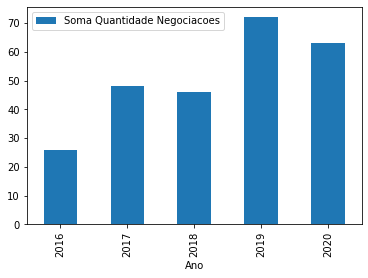

In [ ]:
# Resposta do exercício

resposta.toPandas().plot(x='Ano', y='Soma Quantidade Negociacoes', kind = 'bar')

## Exercício 3 

Qual o total de despesas em salários nos anos de 2016 a 2020 em cada região na qual a equipe está localizada, considerando o cargo de nível junior? Arredonde a soma dos salários para até duas casas decimais. Devem ser exibidas as colunas na ordem e com os nomes especificados a seguir: "ANO", "REGIAO", "TOTALDESPESA". Ordene as linhas exibidas primeiro pelo total de despesa em ordem descendente, e depois pelo ano em ordem descendente. Liste as primeiras 25 linhas da resposta, sem truncamento das strings.

In [ ]:
# Resposta do exercício

resposta = pagamento\
   .join(data, on="dataPK")\
   .join(cargo, on="cargoPK")\
   .join(equipe, on="equipePK")\
   .where("cargoNivel = 'JUNIOR' AND dataAno >= 2016 AND dataAno <= 2020")\
   .select("dataAno", "filialRegiaoNome", "salario")\
   .groupBy("dataAno", "filialRegiaoNome")\
   .sum("salario")\
   .withColumn('sum(salario)', round('sum(salario)', 2))\
   .withColumnRenamed("dataAno", "ANO")\
   .withColumnRenamed("filialRegiaoNome", "REGIAO")\
   .withColumnRenamed("sum(salario)", "TOTALDESPESA")\
   .orderBy(desc("TOTALDESPESA"), desc("ANO"))

resposta.show()

+----+------------+------------+
| ANO|      REGIAO|TOTALDESPESA|
+----+------------+------------+
|2020|     SUDESTE|  1257808.67|
|2019|     SUDESTE|  1257808.67|
|2018|     SUDESTE|  1056208.91|
|2017|     SUDESTE|   876154.55|
|2016|     SUDESTE|   489456.84|
|2020|CENTRO-OESTE|   337073.28|
|2019|CENTRO-OESTE|   337073.28|
|2018|CENTRO-OESTE|   337073.28|
|2020|    NORDESTE|    160832.4|
|2019|    NORDESTE|    160832.4|
|2017|CENTRO-OESTE|   154488.24|
+----+------------+------------+



## Exercício 4 

Mostre o resultado do Exercício 3 usando um diagrama de barras que permite a visualização dos resultados por região.

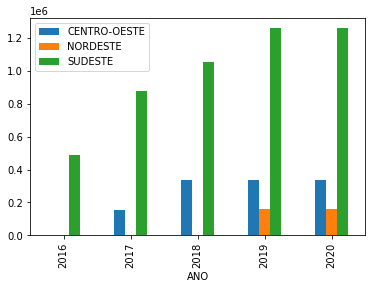

In [ ]:
# Resposta do exercício

legend = ['CENTRO-OESTE', 'NORDESTE', 'SUDESTE']
ax = resposta.toPandas().set_index(['ANO', 'REGIAO']).unstack().plot(kind = 'bar')
ax.legend(legend);

## Exercício 5 

Liste o total dos salários e o total de receitas recebidas, considerando os anos de 2017, 2018 e 2019. Arredonde o total dos salários para até duas casas decimais. Devem ser exibidas as colunas na ordem e com os nomes especificados a seguir: "ANO", "TOTAL GASTO EM SALARIOS", "TOTAL DE RECEITAS RECEBIDAS". Ordene as linhas exibidas pelo ano em ordem descendente. Liste as primeiras 25 linhas da resposta, sem truncamento das *strings*.

In [ ]:
# Resposta do exercício

# Resolvendo o primeiro bloco da consulta
# Qual o total de gastos em salários, considerando cada ano? 
pag = pagamento\
   .join(data, on="dataPK")\
   .select("dataAno", "salario")\
   .where("dataAno BETWEEN 2017 AND 2019")\
   .groupBy("dataAno")\
   .sum("salario")

# Resolvendo o segundo bloco da consulta
# Qual o total de receitas recebidas, considerando cada ano?
neg = negociacao\
   .join(data, on="dataPK")\
   .select("dataAno", "receita")\
   .where("dataAno BETWEEN 2017 AND 2019")\
   .groupBy("dataAno")\
   .sum("receita")

# Realizando a operação de drill across e fazendo as formatações necessárias
resposta = pag\
   .join(neg, on="dataAno")\
   .withColumnRenamed("dataAno", "ANO")\
   .withColumn("sum(salario)", round("sum(salario)",2))\
   .withColumn("sum(receita)", round("sum(receita)",2))\
   .withColumnRenamed("sum(salario)", "TOTAL GASTO EM SALARIOS")\
   .withColumnRenamed("sum(receita)", "TOTAL DE RECEITAS RECEBIDAS")\
   .orderBy(desc("Ano"), desc("ANO"))
   
resposta.show() 

+----+-----------------------+---------------------------+
| ANO|TOTAL GASTO EM SALARIOS|TOTAL DE RECEITAS RECEBIDAS|
+----+-----------------------+---------------------------+
|2019|          1.856766645E7|              3.535331833E7|
|2018|          1.493552647E7|              1.159353966E7|
|2017|             9775279.84|                 7200423.35|
+----+-----------------------+---------------------------+



## Exercício 6 

Mostre o resultado do Exercício 5 usando um diagrama de barras.

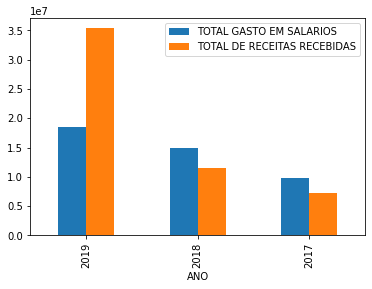

In [ ]:
# Resposta do exercício

resposta.toPandas().set_index(['ANO']).plot(kind = 'bar')

## Exercício 7


Compare a quantidade de negociações que cada uma das equipes realizou nos anos de 2018 e 2019. Devem ser exibidas as colunas na ordem e com os nomes especificados a seguir: "NOME DA EQUIPE", "NOME DA FILIAL", "NEGOCIACOES 2018", "NEGOCIACOES 2019". Ordene as linhas exibidas pelo nome da equipe em ordem ascendente e depois pelo nome da filial em ordem ascendente. Liste as primeiras 25 linhas da resposta, sem truncamento das strings.

Dica: Considere relacionar as equipes por meio da operação drill-across.

In [ ]:
# Resposta do exercício

# Resolvendo o primeiro bloco da consulta
# Qual a quantidade de negociações no ano de 2018? 
neg_2018 = data\
   .join(negociacao, on='dataPK')\
   .join(equipe, on='equipePK')\
   .where('dataAno = 2018')\
   .select('equipeNome', 'filialNome', 'quantidadeNegociacoes')\
   .groupBy('equipeNome', 'filialNome')\
   .sum('quantidadeNegociacoes')\
   .withColumnRenamed('sum(quantidadeNegociacoes)', 'NEGOCIACOES2018')

# Resolvendo o segundo bloco da consulta
# Qual a quantidade de negociações no ano de 2019? 
neg_2019 = data\
   .join(negociacao, on='dataPK')\
   .join(equipe, on='equipePK')\
   .where('dataAno=2019')\
   .select('equipeNome', 'filialNome', 'quantidadeNegociacoes')\
   .groupBy('equipeNome', 'filialNome')\
   .sum('quantidadeNegociacoes')\
   .withColumnRenamed('sum(quantidadeNegociacoes)', 'NEGOCIACOES2019')

neg_2018\
   .join(neg_2019, on=['equipeNome', 'filialNome'])\
   .withColumnRenamed('equipeNome', 'NOME DA EQUIPE')\
   .withColumnRenamed('filialNome', 'NOME DA FILIAL')\
   .withColumn('NEGOCIACOES2018', round('NEGOCIACOES2018',2))\
   .withColumn('NEGOCIACOES2019', round('NEGOCIACOES2019',2))\
   .orderBy('NOME DA EQUIPE', 'NOME DA FILIAL')\
   .show()

+--------------+--------------------+---------------+---------------+
|NOME DA EQUIPE|      NOME DA FILIAL|NEGOCIACOES2018|NEGOCIACOES2019|
+--------------+--------------------+---------------+---------------+
| APP - DESKTOP|RIO DE JANEIRO - ...|            149|            135|
| APP - DESKTOP|SAO PAULO - AV. P...|            132|            135|
|  APP - MOBILE|CAMPO GRANDE - CE...|             98|             88|
|  APP - MOBILE|RIO DE JANEIRO - ...|             99|            112|
|  APP - MOBILE|SAO PAULO - AV. P...|            104|            108|
|           WEB|CAMPO GRANDE - CE...|            100|             95|
|           WEB|RIO DE JANEIRO - ...|             91|            106|
|           WEB|SAO PAULO - AV. P...|             76|             87|
+--------------+--------------------+---------------+---------------+



## Exercício 8 

Liste os setores dos clientes e a soma de suas respectivas receitas para o segundo semestre do ano de 2020. Devem ser exibidas as colunas na ordem e com os nomes especificados a seguir: "SETOR DO CLIENTE", "TOTAL DE RECEITAS". Ordene as linhas exibidas pelo total de receitas em ordem descendente. Liste as primeiras 25 linhas da resposta, sem truncamento das *strings*.

In [ ]:
# Resposta do exercício

negociacao\
   .join(data, on="dataPK")\
   .join(cliente, on="clientePK")\
   .where("dataAno = 2020 AND dataSemestre = 2")\
   .select("clienteSetor", "receita")\
   .groupBy("clienteSetor")\
   .sum("receita")\
   .orderBy("sum(receita)")\
   .withColumn("sum(receita)", round("sum(receita)",2))\
   .withColumnRenamed("clienteSetor", "SETOR DO CLIENTE")\
   .withColumnRenamed("sum(receita)", "TOTAL DE RECEITAS")\
   .orderBy(desc("TOTAL DE RECEITAS"))\
   .show()

+-------------------+-----------------+
|   SETOR DO CLIENTE|TOTAL DE RECEITAS|
+-------------------+-----------------+
|BEBIDAS E ALIMENTOS|       5749704.68|
|              SAUDE|        3119775.3|
|         TECNOLOGIA|       2465926.05|
|          VESTUARIO|       2336266.49|
|            CREDITO|         998789.6|
+-------------------+-----------------+



## Exercício 9 

Analise a resposta do Exercício 8 para identificar qual o setor do cliente que obteve o maior total de receitas. Mostre o total de receitas por mês para esse setor do cliente, considerando o segundo semestre do ano de 2020. Devem ser exibidas as colunas na ordem e com os nomes especificados a seguir: "MES", "TOTAL DE RECEITAS". Ordene as linhas exibidas pelo total de receitas em ordem descendente e depois pelo mês em ordem descendente. Liste as primeiras 25 linhas da resposta, sem truncamento das *strings*.

In [ ]:
# Resposta do exercício

negociacao\
   .join(data, on="dataPK")\
   .join(cliente, on="clientePK")\
   .where("dataAno = 2020 AND dataSemestre = 2 AND clienteSetor = 'BEBIDAS E ALIMENTOS'")\
   .select("dataMes", "receita")\
   .groupBy("dataMes")\
   .sum("receita")\
   .orderBy("dataMes")\
   .withColumn("sum(receita)", round("sum(receita)",2))\
   .withColumnRenamed("dataMes", "MES")\
   .withColumnRenamed("sum(receita)", "TOTAL DE RECEITAS")\
   .orderBy(desc("TOTAL DE RECEITAS"), desc("MES"))\
   .show()

+---+-----------------+
|MES|TOTAL DE RECEITAS|
+---+-----------------+
| 11|        1156403.3|
| 10|       1091389.49|
| 12|         899122.7|
|  9|        877223.55|
|  8|        875934.29|
|  7|        849631.35|
+---+-----------------+



## Exercício 10 

Analise a resposta do Exercício 9 para identificar qual mês gerou o maior total de receitas para o setor de cliente identificado no Exercício 8. Mostre o total de receitas das equipes, considerando o segundo semestre do ano de 2020, o setor de cliente identificado no Exercício 8 e o mês identificado no Exercício 9. Devem ser exibidas as colunas na ordem e com os nomes especificados a seguir: "NOME DA EQUIPE", "NOME DA FILIAL", "TOTAL DE RECEITAS". Ordene as linhas exibidas pelo nome da equipe em ordem ascendente, e depois pelo nome da filial em ordem ascendente. Liste as primeiras 25 linhas da resposta, sem truncamento das *strings*.

In [ ]:
# Resposta do exercício

negociacao\
   .join(data, on="dataPK")\
   .join(cliente, on="clientePK")\
   .join(equipe, on="equipePK")\
   .where("dataAno = 2020 AND dataMes = 11 AND clienteSetor = 'BEBIDAS E ALIMENTOS'")\
   .select("equipeNome", "filialNome", "receita")\
   .groupBy("equipeNome", "filialNome")\
   .sum("receita")\
   .withColumn("sum(receita)", round("sum(receita)", 2))\
   .withColumnRenamed("equipeNome", "NOME DA EQUIPE")\
   .withColumnRenamed("filialNome", "NOME DA FILIAL")\
   .withColumnRenamed("sum(receita)", "TOTAL DE RECEITAS")\
   .orderBy("NOME DA EQUIPE", "NOME DA FILIAL")\
   .show()

+--------------+--------------------+-----------------+
|NOME DA EQUIPE|      NOME DA FILIAL|TOTAL DE RECEITAS|
+--------------+--------------------+-----------------+
| APP - DESKTOP|RIO DE JANEIRO - ...|         35645.65|
| APP - DESKTOP|SAO PAULO - AV. P...|         129409.4|
|  APP - MOBILE|CAMPO GRANDE - CE...|         48714.45|
|  APP - MOBILE|RIO DE JANEIRO - ...|          62138.7|
|  APP - MOBILE|SAO PAULO - AV. P...|         26571.85|
|BI & ANALYTICS|     RECIFE - CENTRO|        527169.75|
|BI & ANALYTICS|SAO PAULO - AV. P...|        149490.15|
|           WEB|CAMPO GRANDE - CE...|         20042.75|
|           WEB|RIO DE JANEIRO - ...|          68596.1|
|           WEB|SAO PAULO - AV. P...|          88624.5|
+--------------+--------------------+-----------------+



## Exercício 11

Liste todas as agregações que podem ser geradas a partir da média dos salários por ano por nome do estado da filial, considerando as equipes localizadas na região de nome SUDESTE. Devem ser exibidas as colunas na ordem e com os nomes especificados a seguir: "ANO", "ESTADO DA FILIAL", "MEDIA DE SALARIOS". Ordene as linhas exibidas pelo estado da filial em ordem descendente, e depois pelo ano em ordem descendente. Liste as primeiras 25 linhas da resposta, sem truncamento das *strings*.

In [ ]:
# Resposta do exercício

pagamento\
   .join(data, on="dataPK")\
   .join(equipe, on="equipePK")\
   .join(cargo, on="cargoPK")\
   .where("filialRegiaoNome = 'SUDESTE'")\
   .select("dataAno", "filialEstadoNome", "salario")\
   .cube("dataAno", "filialEstadoNome")\
   .avg("salario")\
   .withColumn("avg(salario)", round("avg(salario)", 2))\
   .withColumnRenamed("dataAno", "ANO")\
   .withColumnRenamed("filialEstadoNome", "ESTADO DA FILIAL")\
   .withColumnRenamed("avg(salario)", "MEDIA DE SALARIOS")\
   .orderBy(desc("ESTADO DA FILIAL"), desc("ANO"))\
   .show()

+----+----------------+-----------------+
| ANO|ESTADO DA FILIAL|MEDIA DE SALARIOS|
+----+----------------+-----------------+
|2020|       SAO PAULO|          7948.39|
|2019|       SAO PAULO|          7948.39|
|2018|       SAO PAULO|          7986.58|
|2017|       SAO PAULO|           7639.4|
|2016|       SAO PAULO|          7735.52|
|null|       SAO PAULO|          7885.68|
|2020|  RIO DE JANEIRO|          7914.97|
|2019|  RIO DE JANEIRO|          7914.97|
|2018|  RIO DE JANEIRO|          7914.97|
|2017|  RIO DE JANEIRO|          7596.64|
|2016|  RIO DE JANEIRO|          7073.21|
|null|  RIO DE JANEIRO|          7767.22|
|2020|            null|          7935.17|
|2019|            null|          7935.17|
|2018|            null|          7953.29|
|2017|            null|          7621.71|
|2016|            null|          7404.36|
|null|            null|          7835.47|
+----+----------------+-----------------+

